# Regression to Tbet Registration Pipeline

## Data loading

In [104]:
from sidus import io, tools as tl, plotting as pl # import input/output, editing tools, plotting as pl  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ants
from sklearn.metrics import jaccard_score, f1_score
import SimpleITK as sitk
from skimage import exposure
# Fix for Dask DataFrame warning
from dask.config import set
from skimage.exposure import equalize_hist
set({"dataframe.query-planning": True})



### Load clinical data

In [3]:
#Load the axis,regression and tbet clinical data
NAT_samples = pd.read_csv('C:/Users/molanre1/Desktop/WSIFIR/NAT_samples_12.2024.csv') #Change the path to your file
NAT_samples.head(5)

,redcapid,sampleid,slideid,tbet_sampleid,tbet_slideid,reg_sampleid,reg_slideid,RFS,recurrence,lastfollowup,...,analysis_area,specimen_collection,included,paired,model_rvt,ln_status,tumor,regression,good_tissue,pseudo_patient_id
0,239,101,L1_2,834.0,AP0140001,709.0,LY1,83,1.0,2022-11-10 00:00:00,...,59.987766,Post,1,1,0.0,1,1,0,1,1
1,240,107,L2_4,835.0,AP0140002,710.0,LY2,2,0.0,2016-05-01 00:00:00,...,83.479162,Post,1,1,2.0,0,1,1,1,2
2,242,535,L4_3,837.0,AP0140004,712.0,LY4,34,0.0,2019-03-13 00:00:00,...,25.146146,Post,1,1,0.0,0,0,1,1,4
3,243,112,L5_1,838.0,AP0140005,713.0,LY5,47,0.0,2021-07-04 00:00:00,...,52.582683,Post,1,0,0.0,0,0,1,1,5
4,244,114,L6_1,839.0,AP0140006,714.0,LY6,51,0.0,2016-12-12 00:00:00,...,84.902509,Post,1,0,1.0,0,1,1,1,6


In [4]:
#Get corresponding images on each panel. Each row represents corresponding images
ids = NAT_samples[["sampleid","reg_sampleid","tbet_sampleid","slideid","reg_slideid","tbet_slideid"]].copy()

axis_sampleid = NAT_samples['sampleid']
reg_sampleid = NAT_samples['reg_sampleid']
tbet_sampleid = NAT_samples['tbet_sampleid']
axis_slideid = NAT_samples['slideid']
reg_slideid = NAT_samples['reg_slideid']
tbet_slideid = NAT_samples['tbet_slideid']

#Drop the rows with missing values
ids.dropna(inplace=True)

ids.head(46)

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid
0,101,709.0,834.0,L1_2,LY1,AP0140001
1,107,710.0,835.0,L2_4,LY2,AP0140002
2,535,712.0,837.0,L4_3,LY4,AP0140004
3,112,713.0,838.0,L5_1,LY5,AP0140005
4,114,714.0,839.0,L6_1,LY6,AP0140006
5,118,715.0,840.0,L8_2,LY8,AP0140007
6,536,678.0,841.0,L9_3,AP0060001,AP0140008
7,537,679.0,842.0,L10_3,AP0060002,AP0140009
8,125,716.0,843.0,L11_3,LY11,AP0140010
9,129,717.0,844.0,L12_2,LY12,AP0140011


### Load in images from the database

In [5]:
#Initialize the row indexes for all the images

row_indexes = [0,1,2,3,4] #Change to the number of images you want to load
# List to store all images
all_images = []

# Dictionary to store the results of each iteration
results = {}

# Extract the row from the ids table
for row_index in row_indexes:
    selected_row = ids.iloc[row_index]

    # Create variables for each column in the selected row
    reg_sampleid = selected_row['reg_sampleid']
    tbet_sampleid = selected_row['tbet_sampleid']
    reg_slideid = selected_row['reg_slideid']
    tbet_slideid = selected_row['tbet_slideid']

    # Convert variables to integers
    reg_sampleid = int(reg_sampleid)
    tbet_sampleid = int(tbet_sampleid)

    # Save the variables in the dictionary
    results[row_index] = {
        'reg_sampleid': reg_sampleid,
        'tbet_sampleid': tbet_sampleid,
        'reg_slideid': reg_slideid,
        'tbet_slideid': tbet_slideid
    }

    # Load the images
    reg_image = io.load_astropath(sampleid=reg_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_10/{reg_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')
    tbet_image = io.load_astropath(sampleid=tbet_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_12/{tbet_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')

     # Add images to the list
    all_images.extend([reg_image, tbet_image])

# Load the project with all images
sp = io.load_project(samples=all_images, merge_tables=True, modality='astropath')

#Display the spatial data
sp


SpatialData object
├── Images
│     ├── 'sampleid_709_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_710_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_712_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_713_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_714_image': DataTree[cyx] (8, 49152, 32768), (8, 24576, 16384), (8, 12288, 8192), (8, 6144, 4096),

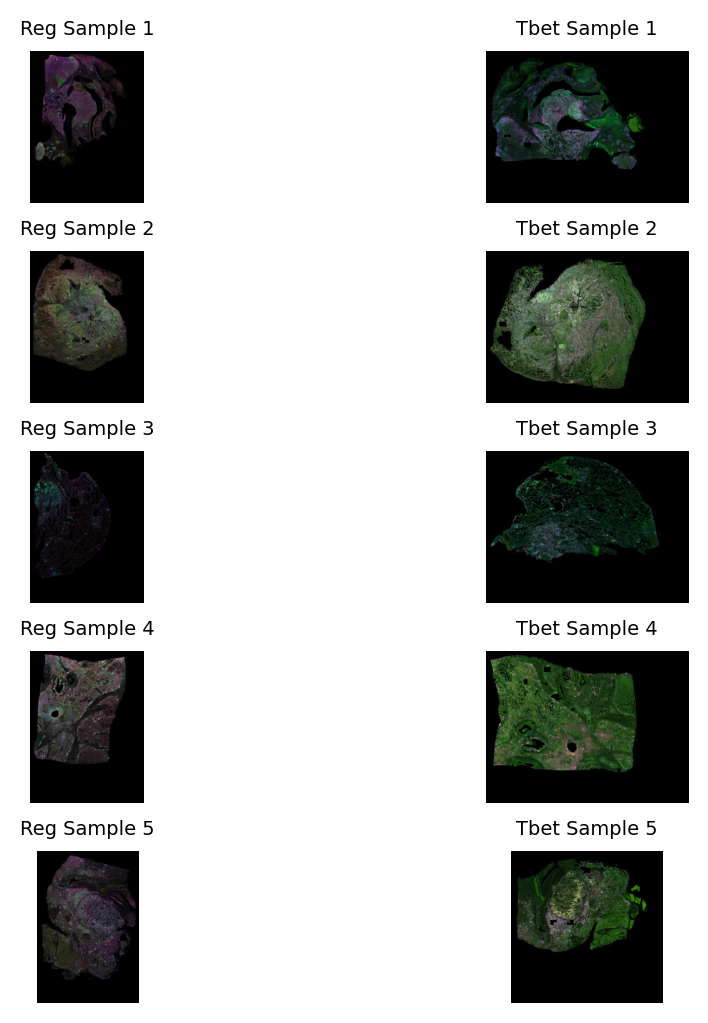

In [6]:
# Plot the first 5 images

pl.SubPlots(
    pl.ShowImage(sdata=sp, sampleid=results[0]['reg_sampleid'], title="Reg Sample 1"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[0]['tbet_sampleid'], title="Tbet Sample 1"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[1]['reg_sampleid'], title="Reg Sample 2"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[1]['tbet_sampleid'], title="Tbet Sample 2"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[2]['reg_sampleid'], title="Reg Sample 3"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[2]['tbet_sampleid'], title="Tbet Sample 3"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[3]['reg_sampleid'], title="Reg Sample 4"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[3]['tbet_sampleid'], title="Tbet Sample 4"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[4]['reg_sampleid'], title="Reg Sample 5"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[4]['tbet_sampleid'], title="Tbet Sample 5"),  # tbet_sampleid
    figsize=(5, 5),
)


## Rigid Registration (Scale 9)

### Load in spatial data 

In [7]:
# Loop through each image in sp.images and crop it
cropped_images = {}
for sampleid in sp.images:
    cropped_images[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=9)[0]


# Convert all images to numpy arrays

cropped_images_arrays = {}
for sampleid, cropped_image in cropped_images.items():
    cropped_images_arrays[sampleid] = cropped_image.compute()



In [8]:
# Convert all images to ants images
cropped_images_ants = {}
for sampleid, cropped_image in cropped_images_arrays.items():
    cropped_images_ants[sampleid] = ants.from_numpy(cropped_image)

cropped_images_ants


{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_834_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_835_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_837_image': ANTsIma

### Pad images

In [9]:

# Create a function to pad all images in cropped_images_ants to the same size

def pad_images_to_same_size(images):
    # Get the maximum dimensions
    max_shape = np.max([img.shape for img in images.values()], axis=0)

    # Pad each image to the maximum dimensions
    padded_images = {}
    for sampleid, img in images.items():
        pad_width = [(0, max_dim - img.shape[i]) for i, max_dim in enumerate(max_shape)]
        padded_images[sampleid] = np.pad(img.numpy(), pad_width, mode='constant', constant_values=0)
    return padded_images
# Pad the images
padded_images = pad_images_to_same_size(cropped_images_ants)

# Convert the padded images to ANTs images
padded_images_ants = {}
for sampleid, padded_image in padded_images.items():
    padded_images_ants[sampleid] = ants.from_numpy(padded_image)

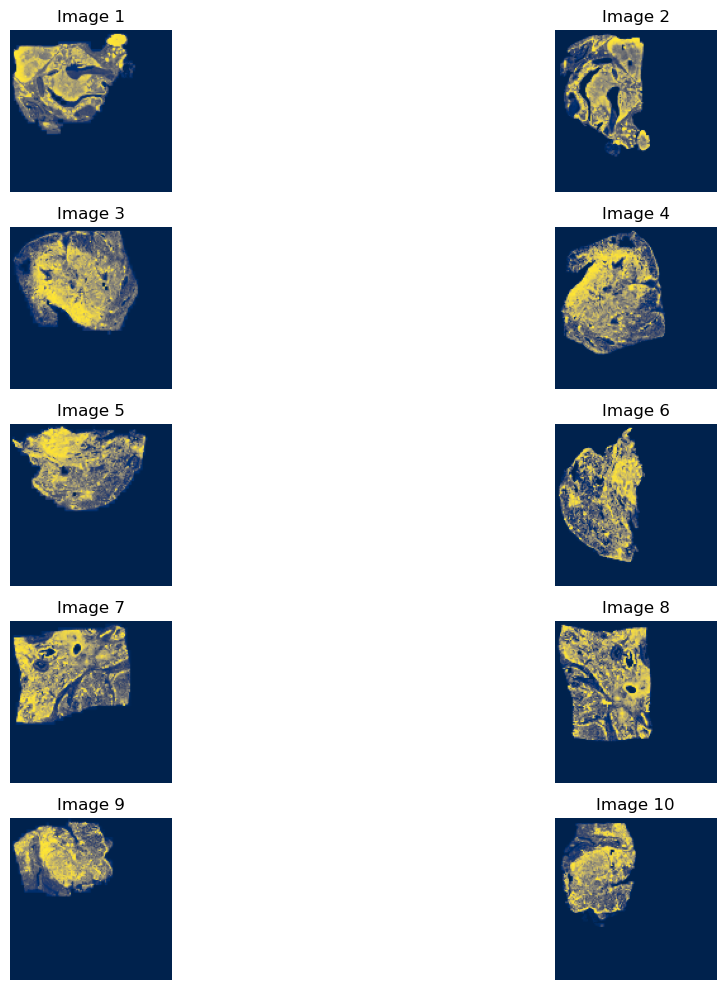

In [10]:
#Plot the first 5 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i < 10:
        equalized_image = exposure.equalize_hist(padded_image.numpy())
        axes[i].imshow(equalized_image,cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Store odd and even images in separate lists: regression and tbet while keeping the key

# Create lists to store regression and tbet image
# images

regression_images = []
tbet_images = []
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i % 2 == 0:  # Even index
        regression_images.append((sampleid, padded_image))
    else:  # Odd index
        tbet_images.append((sampleid, padded_image))

regression_images

[('sampleid_709_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_710_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_712_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_713_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_714_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

In [12]:
tbet_images

[('sampleid_834_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_835_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_837_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_838_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_839_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (128, 128)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

### ANTS Rigid transform 

In [200]:
# Register the regression images to the tbet images

registered_images = {}
for i, ((reg_sampleid, reg_padded_image), (tbet_sampleid, tbet_padded_image)) in enumerate(zip(regression_images, tbet_images)):

    #Apply affine initialization
    
    affine_init = ants.affine_initializer(reg_padded_image, tbet_padded_image,
                                          txfn='C://Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/affine_init.txt',
                                          radian_fraction=0.5)

    # Perform registration
    registered_image = ants.registration(
        fixed=reg_padded_image, 
        moving=tbet_padded_image, 
        initial_transform=affine_init,
        type_of_transform='Rigid',
        outprefix=f'C://Users/molanre1/Desktop/WSIFIR/scale_9_transform/{reg_sampleid}_to_{tbet_sampleid}_',
        verbose=True
    )


    # Apply the transformation to the moving image

    transformed_image = ants.apply_transforms(
        fixed=reg_padded_image, 
        moving=tbet_padded_image, 
        transformlist=registered_image['fwdtransforms']
    )

    # Save the registered image
    registered_images[f'{reg_sampleid}_to_{tbet_sampleid}'] = transformed_image


    

antsRegistration -d 2 -r C://Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/affine_init.txt -m mattes[000001B437BD0E48,000001B437BD16E8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C://Users/molanre1/Desktop/WSIFIR/scale_9_transform/sampleid_709_image_to_sampleid_834_image_,000001B437BD1488,000001B437BD10A8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C://Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/affine_init.txt -m mattes[000001B437BD1228,000001B437BD1708,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C://Users/molanre1/Desktop/WSIFIR/scale_9_transform/sampleid_710_image_to_sampleid_835_image_,000001B437BD1408,000001B437BD12E8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C://Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/affine_init.txt -m mattes[000001B437BD15E8,000001B437BD10A8,1,32,regular

In [201]:
#Read the transformation matrices using ants.read_transform

transformation_matrices = {}
for i, ((reg_sampleid, reg_padded_image), (tbet_sampleid, tbet_padded_image)) in enumerate(zip(regression_images, tbet_images)):
    transformation_matrix = ants.read_transform(f'C://Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat')
    transformation_matrices[f'{reg_sampleid}_to_{tbet_sampleid}'] = transformation_matrix


# Get the fixed parameters and parameters of the transformation matrices
parameters = {}
for key, value in transformation_matrices.items():
    parameters[key] = {
        'paramters': value.parameters,
        'fixed_parameters': value.fixed_parameters
    }
 

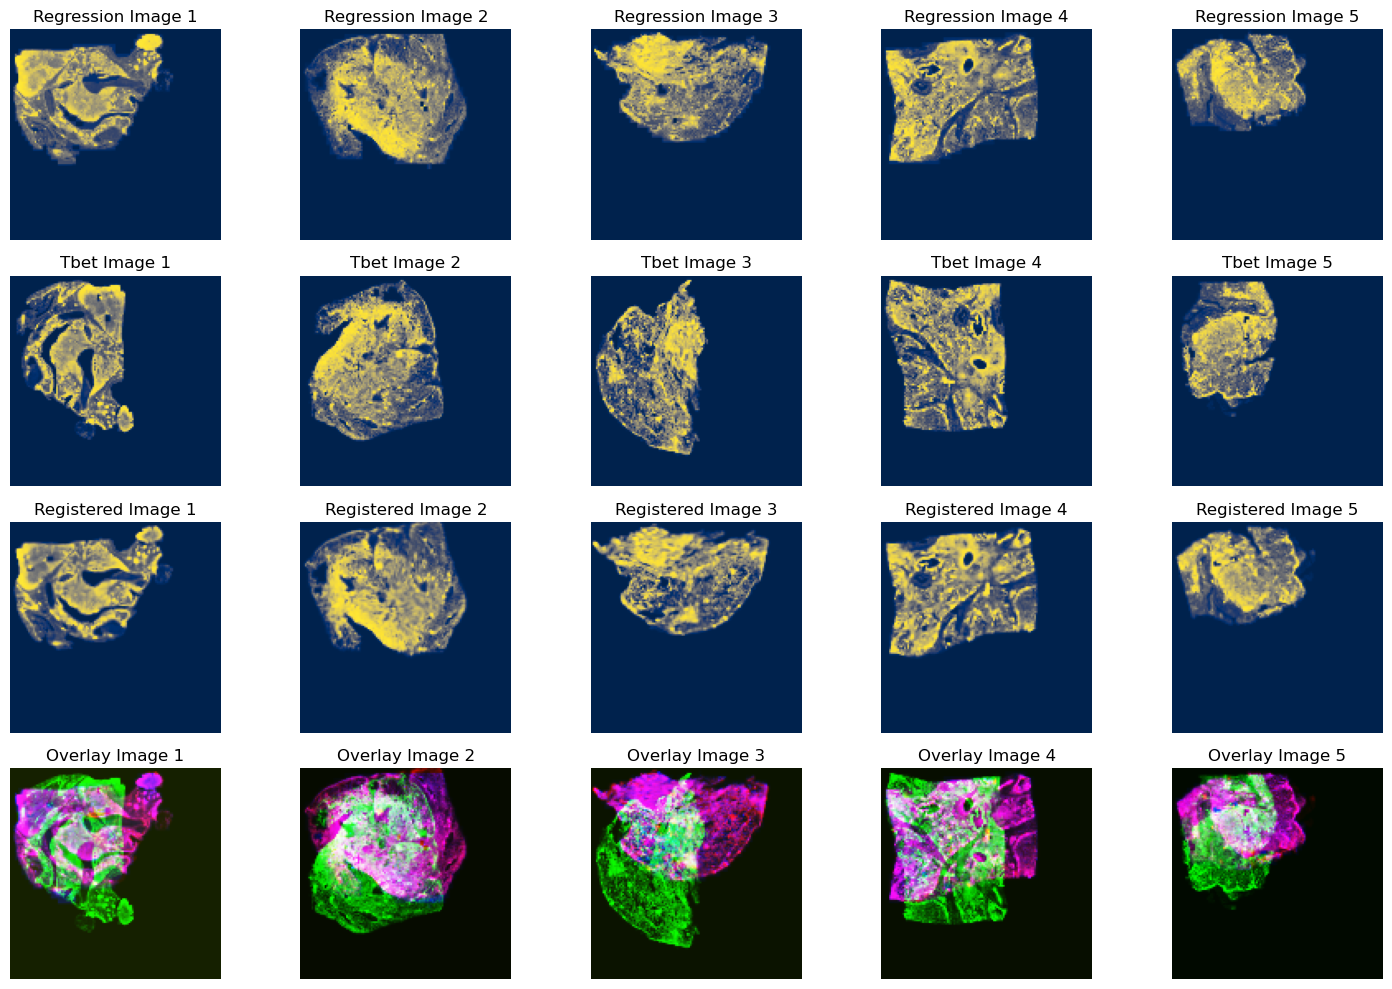

In [202]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

# Plot regression images
for i, (sampleid, padded_image) in enumerate(regression_images):
    if i < 5:
        equalized_image = equalize_hist(padded_image.numpy())
        axes[i].imshow(equalized_image, cmap='cividis')
        axes[i].set_title(f'Regression Image {i+1}')
        axes[i].axis('off')

# Plot tbet images
for i, (sampleid, padded_image) in enumerate(tbet_images):
    if i < 5:
        equalized_image = equalize_hist(padded_image.numpy())
        axes[i + 5].imshow(equalized_image, cmap='cividis')
        axes[i + 5].set_title(f'Tbet Image {i+1}')
        axes[i + 5].axis('off')

# Plot registered images
for i, (sampleid, padded_image) in enumerate(registered_images.items()):
    if i < 5:
        equalized_image = equalize_hist(padded_image.numpy())
        axes[i + 10].imshow(equalized_image, cmap='cividis')
        axes[i + 10].set_title(f'Registered Image {i+1}')
        axes[i + 10].axis('off')

# Plot overlay images
for i, ((reg_sampleid, reg_padded_image), (tbet_sampleid, tbet_padded_image), registered_image) in enumerate(zip(regression_images, tbet_images, registered_images.values())):
    if i < 5:
        # Normalize the images to 0-1 range
        registered_image = (registered_image - registered_image.min()) / (registered_image.max() - registered_image.min())
        tbet_padded_image = (tbet_padded_image - tbet_padded_image.min()) / (tbet_padded_image.max() - tbet_padded_image.min())
        reg_padded_image = (reg_padded_image - reg_padded_image.min()) / (reg_padded_image.max() - reg_padded_image.min())

        # Apply histogram equalization
        registered_image = equalize_hist(registered_image.numpy())
        tbet_padded_image = equalize_hist(tbet_padded_image.numpy())
        reg_padded_image = equalize_hist(reg_padded_image.numpy())

        # Create a color image by stacking the images along the third dimension
        color_image = np.zeros((registered_image.shape[0], registered_image.shape[1], 3), dtype=np.float32)
        color_image[..., 0] = registered_image  # Red channel (registered image)
        color_image[..., 1] = tbet_padded_image  # Green channel (tbet image)
        color_image[..., 2] = reg_padded_image  # Blue channel (regression image)

        # Normalize the combined color image to 0-1 range
        color_image = (color_image - color_image.min()) / (color_image.max() - color_image.min())

        axes[i + 15].imshow(color_image)
        axes[i + 15].set_title(f'Overlay Image {i+1}')
        axes[i + 15].axis('off')

plt.tight_layout()
plt.show()

### Metrics

In [203]:
#Compute mutual information, cross correlation, mse between the fixed regression and moving tbet images 

def compute_metrics(fixed_image, moving_image):

    # Compute Mutual Information
    mutual_info = ants.image_mutual_information(fixed_image, moving_image)

    # Compute Cross Correlation
    cross_corr = ants.math.image_similarity(fixed_image, moving_image,'Correlation')

    # Compute Mean Squared Error
    mse = ants.math.image_similarity(fixed_image, moving_image,'MeanSquares')

    #Binarize the images
    fixed_image_bin = (fixed_image.numpy()> 0.5).astype(int)
    moving_image_bin =  (moving_image.numpy() > 0.5).astype(int)
    # Compute Jaccard Index
    jaccard_index = jaccard_score(fixed_image_bin.flatten(), moving_image_bin.flatten(), average='weighted')
    
    #Compute the Dice coefficient
    f1 = f1_score(fixed_image_bin.flatten(), moving_image_bin.flatten(), average='weighted')

    # Get image from array
    fixed_image = sitk.GetImageFromArray(fixed_image.numpy())
    moving_image = sitk.GetImageFromArray(moving_image.numpy())

    #Compute the Hausdorff distance
    hausdoroff_distance = sitk.HausdorffDistanceImageFilter()
    hausdoroff_distance.Execute(fixed_image, moving_image)
    hausdoroff_distance_value = hausdoroff_distance.GetHausdorffDistance()

    return mutual_info, cross_corr, mse, jaccard_index, f1, hausdoroff_distance_value

In [204]:

#Create a dataframe with the regression and tbet images

metrics_df = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'Mutual Information', 'Cross Correlation', 'Mean Squared Error', 'Jaccard Index', 'F1 Score', 'Hausdorff Distance'])

# Loop through each regression and tbet image pair

for i, ((reg_sampleid, reg_padded_image), (tbet_sampleid, tbet_padded_image)) in enumerate(zip(regression_images, tbet_images)):
    # Compute metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdoroff_distance_value = compute_metrics(reg_padded_image, tbet_padded_image)

    # Concatenate the results
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'Mutual Information': [mutual_info],
        'Cross Correlation': [cross_corr],
        'Mean Squared Error': [mse],
        'Jaccard Index': [jaccard_index],
        'F1 Score': [f1],
        'Hausdorff Distance': [hausdoroff_distance_value]
    })], ignore_index=True)

metrics_df.head(5)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_5084\3870691366.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({


,reg_sampleid,tbet_sampleid,Mutual Information,Cross Correlation,Mean Squared Error,Jaccard Index,F1 Score,Hausdorff Distance
0,sampleid_709_image,sampleid_834_image,-0.115445,-0.116040,4.323702,0.716256,0.827715,30.083218
1,sampleid_710_image,sampleid_835_image,-0.220654,-0.398840,2.541230,0.678180,0.805945,22.135944
2,sampleid_712_image,sampleid_837_image,-0.048569,-0.049528,2.528421,0.573639,0.712836,45.177428
3,sampleid_713_image,sampleid_838_image,-0.193874,-0.253661,2.397359,0.692424,0.815369,23.769729
4,sampleid_714_image,sampleid_839_image,-0.211650,-0.367560,2.156983,0.794676,0.879998,24.000000


In [205]:

#Create a dataframe for the registered images and regression images
metrics_registered_images_df = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'Mutual Information', 'Cross Correlation', 'Mean Squared Error', 'Jaccard Index', 'F1 Score', 'Hausdorff Distance'])

# Loop through each regression and registered image pair
for i, ((reg_sampleid, reg_padded_image), (tbet_sampleid, tbet_padded_image), registered_image) in enumerate(zip(regression_images, tbet_images, registered_images.values())):
    # Compute metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdoroff_distance_value = compute_metrics(reg_padded_image, registered_image)

    # Concatenate the results
    metrics_registered_images_df = pd.concat([metrics_registered_images_df, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'Mutual Information': [mutual_info],
        'Cross Correlation': [cross_corr],
        'Mean Squared Error': [mse],
        'Jaccard Index': [jaccard_index],
        'F1 Score': [f1],
        'Hausdorff Distance': [hausdoroff_distance_value]
    })], ignore_index=True)

metrics_registered_images_df.head(5)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_5084\4260345886.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_registered_images_df = pd.concat([metrics_registered_images_df, pd.DataFrame({


,reg_sampleid,tbet_sampleid,Mutual Information,Cross Correlation,Mean Squared Error,Jaccard Index,F1 Score,Hausdorff Distance
0,sampleid_709_image,sampleid_834_image,-0.517968,-0.866343,1.234979,0.938575,0.968039,6.324555
1,sampleid_710_image,sampleid_835_image,-0.836948,-0.950711,1.226047,0.965028,0.982181,3.000000
2,sampleid_712_image,sampleid_837_image,-0.511704,-0.778999,0.759535,0.936565,0.966970,2.236068
3,sampleid_713_image,sampleid_838_image,-0.879897,-0.942946,0.787456,0.982845,0.991341,2.000000
4,sampleid_714_image,sampleid_839_image,-0.660924,-0.953461,0.898017,0.981996,0.990878,7.071068


In [206]:

metrics_df.drop(columns=['reg_sampleid','tbet_sampleid'], inplace=True)
metrics_registered_images_df.drop(columns=['reg_sampleid','tbet_sampleid'], inplace=True)


In [207]:

# Compute the mean and standard deviation of the metrics
metrics_mean = metrics_df.mean()
metrics_std = metrics_df.std()
metrics_registered_images_mean = metrics_registered_images_df.mean()
metrics_registered_images_std = metrics_registered_images_df.std()
# Create a dataframe with the mean and standard deviation of the metrics
metrics_mean_df = pd.DataFrame({
    'Mean': metrics_mean,
    'Standard Deviation': metrics_std
})
metrics_registered_images_mean_df = pd.DataFrame({
    'Mean': metrics_registered_images_mean,
    'Standard Deviation': metrics_registered_images_std
})

# Concatenate the two dataframes
metrics_combined_df = pd.concat([metrics_mean_df['Mean'], metrics_registered_images_mean_df['Mean'], metrics_mean_df['Standard Deviation'], metrics_registered_images_mean_df['Standard Deviation']], axis=1) 
metrics_combined_df.columns = ['Mean', 'Mean Registered', 'Standard Deviation', 'Standard Deviation Registered']
metrics_combined_df


,Mean,Mean Registered,Standard Deviation,Standard Deviation Registered
Mutual Information,-0.158039,-0.681488,0.073954,0.172860
Cross Correlation,-0.237126,-0.898492,0.152719,0.075889
Mean Squared Error,2.789539,0.981207,0.871411,0.233423
Jaccard Index,0.691035,0.961002,0.079572,0.022551
F1 Score,0.808373,0.979882,0.060594,0.011879
Hausdorff Distance,29.033264,4.126338,9.517720,2.390955


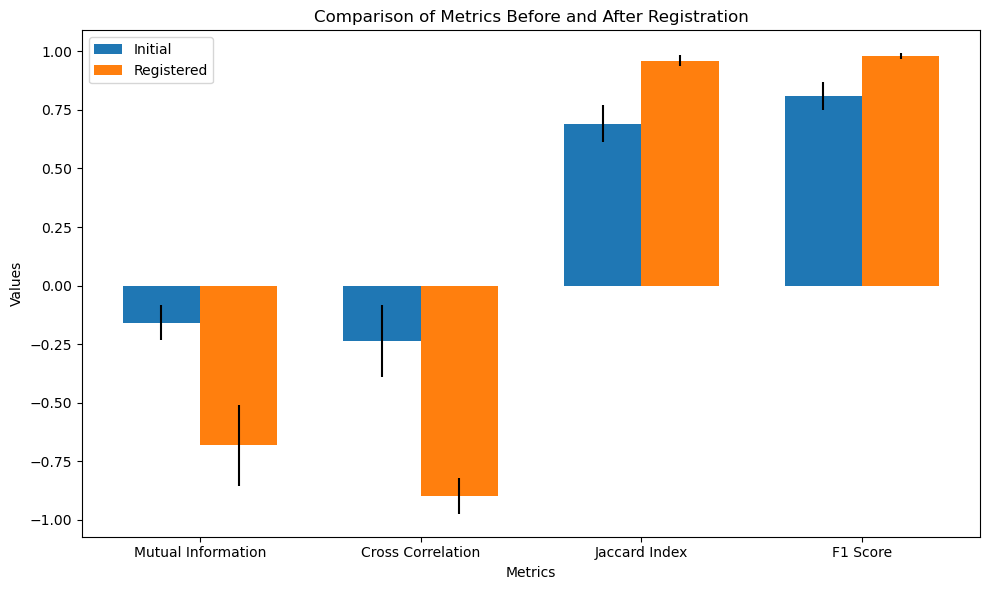

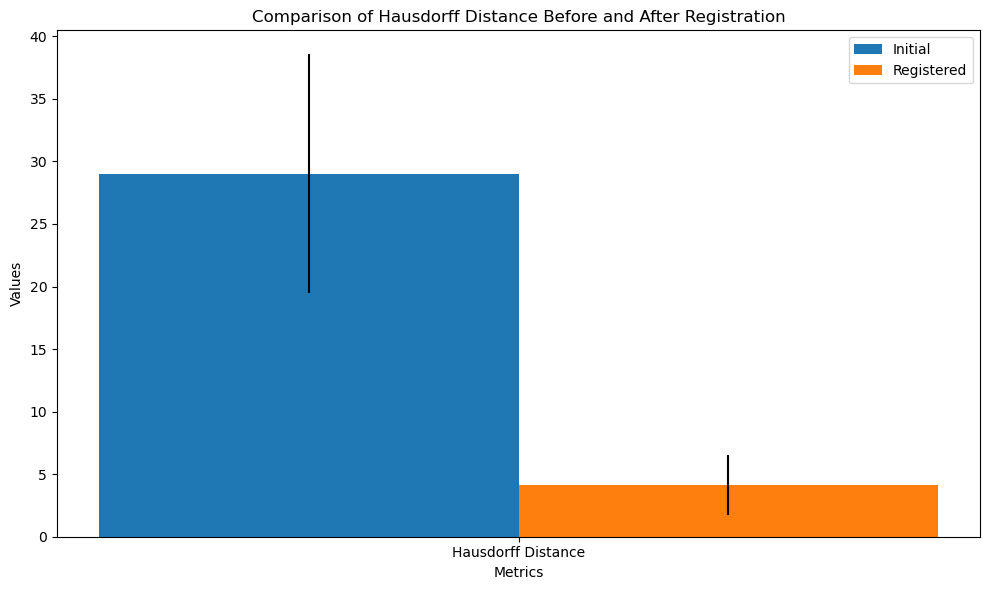

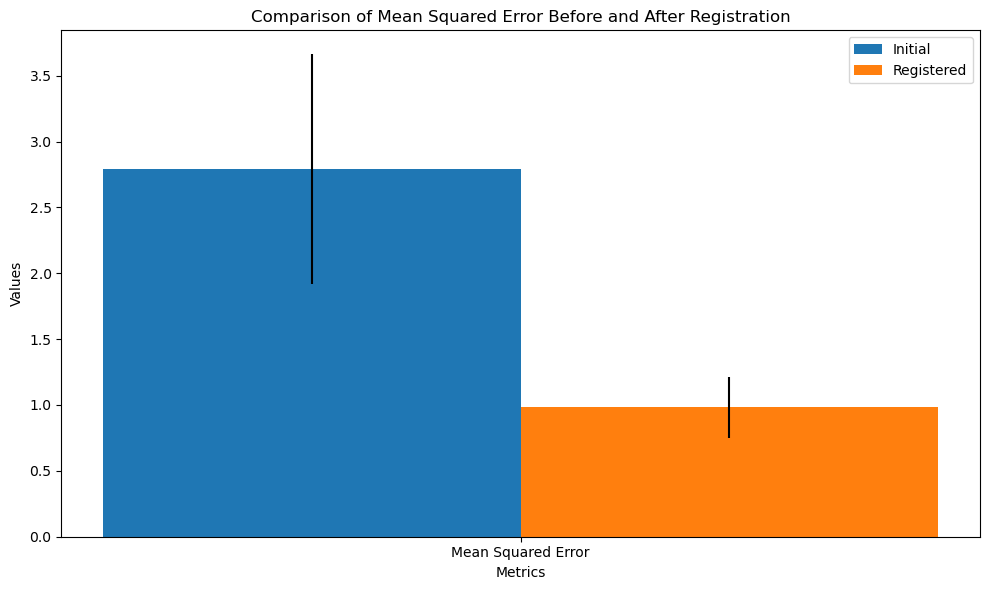

In [208]:

# Create grouped bar plots for the metrics and metrics_registered_images for each metric without hausdorff distance

#Create a new dataframe without Haudorff distance or Mean Squared Error
metrics_mean_df_drop = metrics_mean_df.drop(index=['Hausdorff Distance', 'Mean Squared Error'])
metrics_registered_images_mean_df_drop = metrics_registered_images_mean_df.drop(index=['Hausdorff Distance', 'Mean Squared Error'])

# Create a new dataframe with only Haudorff distance
metrics_hausdorff_df = metrics_mean_df.loc[['Hausdorff Distance']]
metrics_registered_images_hausdorff_df = metrics_registered_images_mean_df.loc[['Hausdorff Distance']]

# Create a new dataframe with only Mean Squared Error
metrics_mse_df = metrics_mean_df.loc[['Mean Squared Error']]
metrics_registered_images_mse_df = metrics_registered_images_mean_df.loc[['Mean Squared Error']]

def plot_grouped_bar_chart(df1, df2, title):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Set the bar width
    bar_width = 0.35

    # Set the x locations for the bars
    x = np.arange(len(df1))

    # Create the bars for df1
    plt.bar(x, df1['Mean'], yerr=df1['Standard Deviation'], width=bar_width, label='Initial')

    # Create the bars for df2
    plt.bar(x + bar_width, df2['Mean'], yerr=df2['Standard Deviation'], width=bar_width, label='Registered')

    # Add labels and title
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title(title)
    plt.xticks(x + bar_width / 2, df1.index)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
# Plot the grouped bar chart for metrics_df and metrics_registered_images_df
plot_grouped_bar_chart(metrics_mean_df_drop, metrics_registered_images_mean_df_drop, 'Comparison of Metrics Before and After Registration')
# Plot the grouped bar chart for metrics_hausdorff_df and metrics_registered_images_hausdorff_df
plot_grouped_bar_chart(metrics_hausdorff_df, metrics_registered_images_hausdorff_df, 'Comparison of Hausdorff Distance Before and After Registration')
# Plot the grouped bar chart for metrics_mse_df and metrics_registered_images_mse_df
plot_grouped_bar_chart(metrics_mse_df, metrics_registered_images_mse_df, 'Comparison of Mean Squared Error Before and After Registration')


In [209]:

# Compute the difference between the metrics of the mean
diff_mean = metrics_registered_images_mean_df['Mean'] - metrics_mean_df['Mean']

# Create a dataframe with the difference between the metrics of the mean and standard deviation
diff_df = pd.DataFrame({
    'Difference Mean': diff_mean,
})

diff_df



,Difference Mean
Mutual Information,-0.523449
Cross Correlation,-0.661366
Mean Squared Error,-1.808332
Jaccard Index,0.269967
F1 Score,0.171509
Hausdorff Distance,-24.906925


In [210]:

# Save the DataFrame to CSV file
diff_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet_metrics_diff_mean_df.csv', index=False)


     

In [211]:

#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 2 different slices representing the same tissue stained with regression and tbet panels

# Create a DataFrame to store the merged images
merged_df = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid','final_image_parameters', 'final_image_fixed_parameters'])

# Loop through each regression and tbet image pair

for i, ((reg_sampleid, reg_padded_image), (tbet_sampleid, tbet_padded_image), registered_image) in enumerate(zip(regression_images, tbet_images, registered_images.values())):
    # Get the transformation matrix
    transformation_matrix = transformation_matrices[f'{reg_sampleid}_to_{tbet_sampleid}']

    # Get the parameters and fixed parameters
    final_image_parameters = transformation_matrix.parameters
    final_image_fixed_parameters = transformation_matrix.fixed_parameters

    # Concatenate the results
    merged_df = pd.concat([merged_df, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'final_image_parameters': [final_image_parameters],
        'final_image_fixed_parameters': [final_image_fixed_parameters]
    })], ignore_index=True)

merged_df.head(5)


,reg_sampleid,tbet_sampleid,final_image_parameters,final_image_fixed_parameters
0,sampleid_709_image,sampleid_834_image,"[0.9999651312828064, -0.008348815143108368, 0....","[30.321826934814453, 41.447025299072266]"
1,sampleid_710_image,sampleid_835_image,"[0.9995615482330322, -0.029608337208628654, 0....","[30.321826934814453, 41.447025299072266]"
2,sampleid_712_image,sampleid_837_image,"[0.9980959296226501, -0.061681147664785385, 0....","[30.321826934814453, 41.447025299072266]"
3,sampleid_713_image,sampleid_838_image,"[0.9999686479568481, -0.007921624928712845, 0....","[30.321826934814453, 41.447025299072266]"
4,sampleid_714_image,sampleid_839_image,"[0.9999898076057434, 0.004521005321294069, -0....","[30.321826934814453, 41.447025299072266]"


In [212]:
#Save the merged DataFrame to a CSV file
merged_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_9.csv', index=False)


## Rigid Registration (Scale 7)

### Load in spatial data

In [117]:
# Loop through each image in sp.images and crop it
cropped_images_2 = {}
for sampleid in sp.images:
    cropped_images_2[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=7)[0]


     

In [118]:

# Convert all images to numpy arrays
cropped_images_arrays_2 = {}
for sampleid, cropped_image in cropped_images_2.items():
    cropped_images_arrays_2[sampleid] = cropped_image.compute()


In [119]:
#Convert all images to ants images
cropped_images_ants_2 = {}
for sampleid, cropped_image in cropped_images_arrays_2.items():
    cropped_images_ants_2[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_2


{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_834_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 384)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_835_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 384)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_837_image': AN

### Pad images

In [245]:

# Pad the images
padded_images_2 = pad_images_to_same_size(cropped_images_ants_2)

# Convert the padded images to ANTs images
padded_images_ants_2 = {}
for sampleid, padded_image in padded_images_2.items():
    padded_images_ants_2[sampleid] = ants.from_numpy(padded_image)

padded_images_ants_2

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_834_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_835_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_837_image': AN

In [260]:
# Store odd and even images in separate lists: regression and tbet while keeping the key

# Create lists to store regression and tbet image
# images

regression_images_2 = []
tbet_images_2 = []
for i, (sampleid, cropped_image) in enumerate(padded_images_ants_2.items()):
    if i % 2 == 0:  # Even index
        regression_images_2.append((sampleid, cropped_image))
    else:  # Odd index
        tbet_images_2.append((sampleid, cropped_image))
        
regression_images_2

[('sampleid_709_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_710_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_712_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_713_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_714_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

In [261]:
tbet_images_2

[('sampleid_834_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_835_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_837_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_838_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_839_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (512, 512)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

### Scale and apply registration parameters at lower resolution to higher resolution image

In [262]:

def compute_scaling_factor(higher_res_scale, lower_res_scale):
    """
    Compute the scaling factor based on the image transformations.
    """
    # Directly compute the scaling factor as a scalar
    return lower_res_scale / higher_res_scale
 
def scale_transform(transform_path, scaling_factors):
    """
    Scale a 2D affine transformation matrix while preserving rotation components.
    
    Parameters:
        transform_path (str): Path to the original transformation matrix (.mat file).
        scaling_factors (list or float): Scaling factors for translation components. 
                                         Can be a scalar or a list of 2 values for 2D transformations.
    
    Returns:
        str: Path to the scaled transformation matrix.
    """
    try:
        # Read the transformation matrix
        transform = ants.read_transform(transform_path)
        
        # Ensure the transform is 2D
        if transform.dimension != 2:
            raise ValueError("This function only supports 2D transformations.")
        
        # Extract the transformation parameters
        parameters = np.array(transform.parameters)  # Convert to a NumPy array for easier manipulation
        
        # Validate scaling_factors
        if isinstance(scaling_factors, (int, float)):  # If scalar, apply uniformly
            scaling_factors = [scaling_factors] * 2
        elif len(scaling_factors) != 2:
            raise ValueError("Scaling factors must be a scalar or a list of 2 values for 2D transformations.")
        
        # Scale only the translation components (last two parameters for tx, ty in 2D affine)
        scaled_parameters = parameters.copy()
        if len(parameters) >= 6:  # Ensure there are enough parameters for a 2D affine transform
            scaled_parameters[4:6] *= scaling_factors  # Scale translation components (tx, ty)
        else:
            raise ValueError("Transformation parameters do not have enough components to scale translation.")
        
        # Create a new transform with the scaled parameters
        scaled_transform = ants.create_ants_transform(
            transform_type=transform.type,  # Use the same transform type
            dimension=transform.dimension,  # Use the same dimension (2D)
            parameters=scaled_parameters.tolist(),  # Convert back to a list
            fixed_parameters=transform.fixed_parameters  # Keep the fixed parameters unchanged
        )
        
        # Save the scaled transformation matrix
        scaled_transform_path = transform_path.replace('.mat', '_scaled.mat')
        ants.write_transform(scaled_transform, scaled_transform_path)
        
        return scaled_transform_path
    
    except Exception as e:
        raise RuntimeError(f"Error scaling transform: {e}")


#Compute the scaling factor between an image from scale 9 and scale 7

scaling_factor_1 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale9'].image.transform['scale0'].scale[0])

#Convert the scaling factors to be floats
scaling_factor_1 = float(scaling_factor_1)
print(scaling_factor_1)


4.0


In [263]:
#Scale each transformation matrix by the scaling factor

scaled_transformations = {}
for key, value in transformation_matrices.items():
    # Get the original transformation matrix
    transform_path = f'C://Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/{key}_0GenericAffine.mat'
    
    # Scale the transformation matrix
    scaled_transform_path = scale_transform(transform_path, scaling_factor_1)
    
    # Store the scaled transformation path
    scaled_transformations[key] = scaled_transform_path

### ANTS Rigid transform

antsRegistration -d 2 -r C://Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/affine_init.txt -m mattes[000001B437D0CE68,000001B42D5523E8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C://Users/molanre1/Desktop/WSIFIR/scale_7_transform/sampleid_709_image_to_sampleid_834_image_,000001B42D655628,000001B42DCECF08] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C://Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/affine_init.txt -m mattes[000001B42DCECF08,000001B429D55608,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C://Users/molanre1/Desktop/WSIFIR/scale_7_transform/sampleid_710_image_to_sampleid_835_image_,000001B42D5523E8,000001B42D655628] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C://Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/affine_init.txt -m mattes[000001B4324C9DC8,000001B431D12CE8,1,32,regular

In [291]:
#Read the transformation matrices using ants.read_transform

transformation_matrices_scaled = {}
for i, ((reg_sampleid, reg_padded_image), (tbet_sampleid, tbet_padded_image)) in enumerate(zip(regression_images_2, tbet_images_2)):
    transformation_matrix = ants.read_transform(f'C://Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat')
    transformation_matrices_scaled[f'{reg_sampleid}_to_{tbet_sampleid}'] = transformation_matrix

# Get the fixed parameters and parameters of the transformation matrices
parameters_scaled = {}
for key, value in transformation_matrices_scaled.items():
    parameters_scaled[key] = {
        'paramters': value.parameters,
        'fixed_parameters': value.fixed_parameters
    }

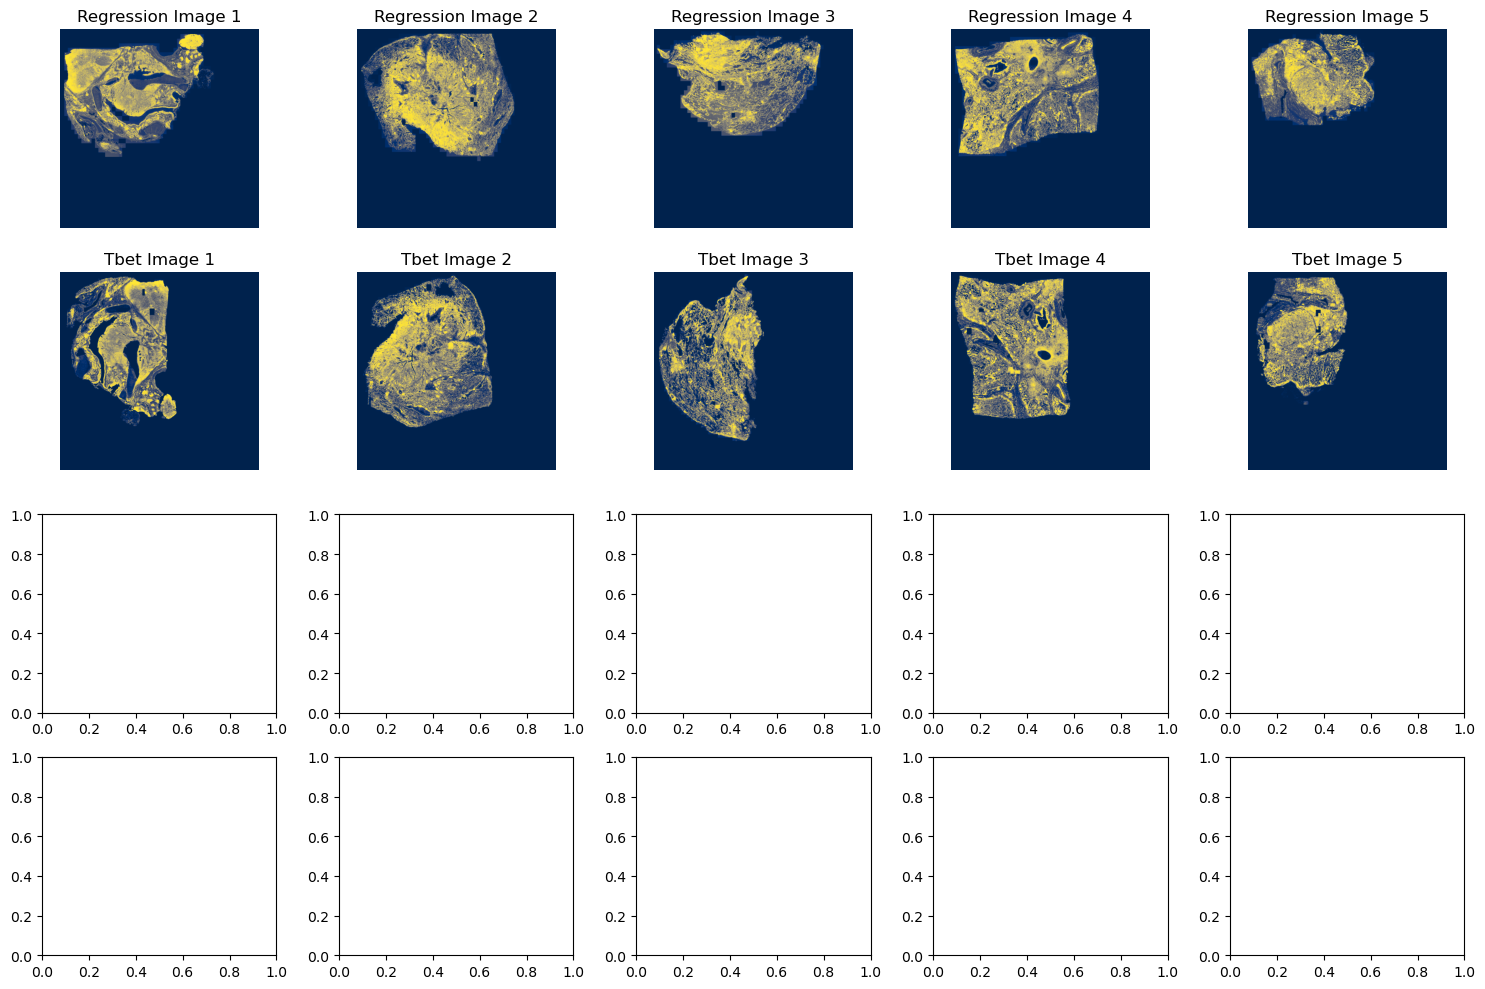

In [292]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()
# Plot regression images
for i, (sampleid, padded_image) in enumerate(regression_images_2):
    if i < 5:
        equalized_image = equalize_hist(padded_image.numpy())
        axes[i].imshow(equalized_image, cmap='cividis')
        axes[i].set_title(f'Regression Image {i+1}')
        axes[i].axis('off')

# Plot tbet images
for i, (sampleid, padded_image) in enumerate(tbet_images_2):
    if i < 5:
        equalized_image = equalize_hist(padded_image.numpy())
        axes[i + 5].imshow(equalized_image, cmap='cividis')
        axes[i + 5].set_title(f'Tbet Image {i+1}')
        axes[i + 5].axis('off')

# Plot registered images
for i, (sampleid, padded_image) in enumerate(registered_images_scaled.items()):
    if i < 5:
        equalized_image = equalize_hist(padded_image.numpy())
        axes[i + 10].imshow(equalized_image, cmap='cividis')
        axes[i + 10].set_title(f'Registered Image {i+1}')
        axes[i + 10].axis('off')

# Plot overlay images
for i, ((reg_sampleid, reg_padded_image), (tbet_sampleid, tbet_padded_image), registered_image_scaled) in enumerate(zip(regression_images_2, tbet_images_2, registered_images_scaled.values())):
    if i < 5:
        # Normalize the images to 0-1 range
        registered_image_scaled = (registered_image_scaled - registered_image_scaled.min()) / (registered_image_scaled.max() - registered_image_scaled.min())
        tbet_padded_image = (tbet_padded_image - tbet_padded_image.min()) / (tbet_padded_image.max() - tbet_padded_image.min())
        reg_padded_image = (reg_padded_image - reg_padded_image.min()) / (reg_padded_image.max() - reg_padded_image.min())

        # Apply histogram equalization
        registered_image_scaled = equalize_hist(registered_image_scaled.numpy())
        tbet_padded_image = equalize_hist(tbet_padded_image.numpy())
        reg_padded_image = equalize_hist(reg_padded_image.numpy())

        # Create a color image by stacking the images along the third dimension
        color_image = np.zeros((registered_image_scaled.shape[0], registered_image_scaled.shape[1], 3), dtype=np.float32)
        color_image[..., 0] = registered_image_scaled  # Red channel (registered image)
        color_image[..., 1] = tbet_padded_image  # Green channel (tbet image)
        color_image[..., 2] = reg_padded_image  # Blue channel (regression image)

        # Normalize the combined color image to 0-1 range
        color_image = (color_image - color_image.min()) / (color_image.max() - color_image.min())

        axes[i + 15].imshow(color_image)
        axes[i + 15].set_title(f'Overlay Image {i+1}')
        axes[i + 15].axis('off')

plt.tight_layout()
plt.show()

In [42]:
#View image metadata
rigid_result_4

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image4_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image4_0GenericAffine.mat']}

In [43]:
#Get transform parameters
fwd_aff_4 = ants.read_transform(rigid_result_4['fwdtransforms'][0])
fwd_aff_4.parameters

array([ 0.94235522, -0.3346141 ,  0.3346141 ,  0.94235522, 48.92260361,
       33.29934311])

In [44]:
fwd_aff_4.fixed_parameters

array([41.98567581, 35.21538925])

In [45]:
#View image metadata
rigid_result_5

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image5_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image5_0GenericAffine.mat']}

In [46]:
fwd_aff_5 = ants.read_transform(rigid_result_5['fwdtransforms'][0])
fwd_aff_5.parameters


array([  0.91440165,   0.27236712,  -0.31912923,   1.04244566,
       -56.38703537, 103.29453278])

In [47]:
fwd_aff_5.fixed_parameters

array([52.7854805 , 42.12069702])

In [48]:
#View image metadata
rigid_result_6

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image6_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image6_0GenericAffine.mat']}

In [49]:
fwd_aff_6 = ants.read_transform(rigid_result_6['fwdtransforms'][0])
fwd_aff_6.parameters

array([  0.9255389 ,   0.29767665,  -0.36522287,   1.10652769,
       -71.6918335 , 114.26847076])

In [50]:
fwd_aff_6.fixed_parameters

array([50.77205276, 28.47519302])

### Metrics

In [51]:
#Compute mutual information between the fixed regression and  transformed reg-tbet image pre/post registration
mi4_pre = ants.image_mutual_information(reg_image_cropped_ants_4_padded, tbet_image_cropped_ants_4_padded)
mi5_pre = ants.image_mutual_information(reg_image_cropped_ants_5_padded, tbet_image_cropped_ants_5_padded)
mi6_pre = ants.image_mutual_information(reg_image_cropped_ants_6_padded, tbet_image_cropped_ants_6_padded)

mi4_post = ants.image_mutual_information(reg_image_cropped_ants_4_padded, rigid_transformed_image_4)
mi5_post = ants.image_mutual_information(reg_image_cropped_ants_5_padded, rigid_transformed_image_5)
mi6_post = ants.image_mutual_information(reg_image_cropped_ants_6_padded, rigid_transformed_image_6)

#Compute normalized cross correlation between the fixed regression and  transformed reg-tbet image pre/post registration
cc4_pre = ants.math.image_similarity(reg_image_cropped_ants_4_padded,tbet_image_cropped_ants_4_padded, 'Correlation')
cc5_pre = ants.math.image_similarity(reg_image_cropped_ants_5_padded, tbet_image_cropped_ants_5_padded, 'Correlation')
cc6_pre = ants.math.image_similarity(reg_image_cropped_ants_6_padded, tbet_image_cropped_ants_6_padded, 'Correlation')

cc4_post = ants.math.image_similarity(reg_image_cropped_ants_4_padded, rigid_transformed_image_4, 'Correlation')
cc5_post = ants.math.image_similarity(reg_image_cropped_ants_5_padded, rigid_transformed_image_5, 'Correlation')
cc6_post  = ants.math.image_similarity(reg_image_cropped_ants_6_padded, rigid_transformed_image_6, 'Correlation')

#Compute mean squares between the fixed regression and  transformed axis-reg image reg-tbet registration
mse4_pre = ants.math.image_similarity(reg_image_cropped_ants_4_padded,tbet_image_cropped_ants_4_padded, 'MeanSquares')
mse5_pre = ants.math.image_similarity(reg_image_cropped_ants_5_padded, tbet_image_cropped_ants_5_padded, 'MeanSquares')
mse6_pre = ants.math.image_similarity(reg_image_cropped_ants_6_padded, tbet_image_cropped_ants_6_padded, 'MeanSquares')

mse4_post = ants.math.image_similarity(reg_image_cropped_ants_4_padded, rigid_transformed_image_4, 'MeanSquares')
mse5_post = ants.math.image_similarity(reg_image_cropped_ants_5_padded, rigid_transformed_image_5, 'MeanSquares')
mse6_post = ants.math.image_similarity(reg_image_cropped_ants_6_padded, rigid_transformed_image_6, 'MeanSquares')


In [52]:
# Binarize the arrays (threshold = 0.5) to create binary masks
reg_image_cropped_ants_4_binary = (reg_image_cropped_ants_4_padded.numpy() > 0.5).astype(int)
reg_image_cropped_ants_5_binary = (reg_image_cropped_ants_5_padded.numpy() > 0.5).astype(int)
reg_image_cropped_ants_6_binary = (reg_image_cropped_ants_6_padded.numpy() > 0.5).astype(int)

tbet_image_cropped_ants_4_binary = (tbet_image_cropped_ants_4_padded.numpy() > 0.5).astype(int)
tbet_image_cropped_ants_5_binary = (tbet_image_cropped_ants_5_padded.numpy() > 0.5).astype(int)
tbet_image_cropped_ants_6_binary = (tbet_image_cropped_ants_6_padded.numpy() > 0.5).astype(int)

rigid_result_4_binary = (rigid_transformed_image_4.numpy() > 0.5).astype(int)
rigid_result_5_binary = (rigid_transformed_image_5.numpy() > 0.5).astype(int)
rigid_result_6_binary = (rigid_transformed_image_6.numpy() > 0.5).astype(int)

In [53]:
# Compute Jaccard Index pre/post registration
jaccard_4_pre = jaccard_score(reg_image_cropped_ants_4_binary.flatten(), tbet_image_cropped_ants_4_binary.flatten())
jaccard_5_pre = jaccard_score(reg_image_cropped_ants_5_binary.flatten(), tbet_image_cropped_ants_5_binary.flatten())
jaccard_6_pre = jaccard_score(reg_image_cropped_ants_6_binary.flatten(), tbet_image_cropped_ants_6_binary.flatten())

jaccard_4_post = jaccard_score(reg_image_cropped_ants_4_binary.flatten(), rigid_result_4_binary.flatten())
jaccard_5_post = jaccard_score(reg_image_cropped_ants_5_binary.flatten(), rigid_result_5_binary.flatten())
jaccard_6_post = jaccard_score(reg_image_cropped_ants_6_binary.flatten(), rigid_result_6_binary.flatten())


# Compute Dice Similarity Score pre/post registration
dice4_pre = f1_score(reg_image_cropped_ants_4_binary.flatten(), tbet_image_cropped_ants_4_binary.flatten())
dice5_pre = f1_score(reg_image_cropped_ants_5_binary.flatten(), tbet_image_cropped_ants_5_binary.flatten())
dice6_pre = f1_score(reg_image_cropped_ants_6_binary.flatten(), tbet_image_cropped_ants_6_binary.flatten())

dice4_post = f1_score(reg_image_cropped_ants_4_binary.flatten(), rigid_result_4_binary.flatten())
dice5_post = f1_score(reg_image_cropped_ants_5_binary.flatten(), rigid_result_5_binary.flatten())
dice6_post = f1_score(reg_image_cropped_ants_6_binary.flatten(), rigid_result_6_binary.flatten())


In [54]:
# Convert the images to SimpleITK format
sitk_initial_image_4 = sitk.GetImageFromArray(reg_image_cropped_ants_4_padded.numpy())
sitk_moving_image_4 = sitk.GetImageFromArray(tbet_image_cropped_ants_4_padded.numpy())
sitk_final_image_4 = sitk.GetImageFromArray(rigid_transformed_image_4.numpy())

sitk_initial_image_5 = sitk.GetImageFromArray(reg_image_cropped_ants_5_padded.numpy())
sitk_moving_image_5 = sitk.GetImageFromArray(tbet_image_cropped_ants_5_padded.numpy())
sitk_final_image_5 = sitk.GetImageFromArray(rigid_transformed_image_5.numpy())

sitk_initial_image_6 = sitk.GetImageFromArray(reg_image_cropped_ants_6_padded.numpy())
sitk_moving_image_6 = sitk.GetImageFromArray(tbet_image_cropped_ants_6_padded.numpy())
sitk_final_image_6 = sitk.GetImageFromArray(rigid_transformed_image_6.numpy())

# Compute Hausdorff Distance using SimpleITK pre/post registration
hausdorff_filter_4_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_4_pre.Execute(sitk_initial_image_4, sitk_moving_image_4)
hausdorff_sitk_4_pre = hausdorff_filter_4_pre.GetHausdorffDistance()

hausdorff_filter_4_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_4_post.Execute(sitk_initial_image_4, sitk_final_image_4)
hausdorff_sitk_4_post = hausdorff_filter_4_post.GetHausdorffDistance()

hausdorff_filter_5_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_5_pre.Execute(sitk_initial_image_5, sitk_moving_image_5)
hausdorff_sitk_5_pre = hausdorff_filter_5_pre.GetHausdorffDistance()

hausdorff_filter_5_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_5_post.Execute(sitk_initial_image_5, sitk_final_image_5)
hausdorff_sitk_5_post = hausdorff_filter_5_post.GetHausdorffDistance()

hausdorff_filter_6_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_6_pre.Execute(sitk_initial_image_6, sitk_moving_image_6)
hausdorff_sitk_6_pre = hausdorff_filter_6_pre.GetHausdorffDistance()

hausdorff_filter_6_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_6_post.Execute(sitk_initial_image_6, sitk_final_image_6)
hausdorff_sitk_6_post = hausdorff_filter_6_post.GetHausdorffDistance()

In [55]:
#Display the mi, cc, mse, jaccard, dice and hausdorff distance as graphs
metrics_df_1 = pd.DataFrame({   
    'Sample': ['Reg-Tbet Image 4', 'Reg-Tbet Image 5', 'Reg-Tbet Image 6'],
    'MI_pre': [mi4_pre, mi5_pre, mi6_pre],
    'MI_post': [mi4_post, mi5_post, mi6_post],
    'CC_pre': [cc4_pre, cc5_pre, cc6_pre],
    'CC_post': [cc4_post, cc5_post, cc6_post],
    'MSE_pre': [mse4_pre, mse5_pre, mse6_pre],
    'MSE_post': [mse4_post, mse5_post, mse6_post],
    'Jaccard_pre': [jaccard_4_pre, jaccard_5_pre, jaccard_6_pre],
    'Jaccard_post': [jaccard_4_post, jaccard_5_post, jaccard_6_post],
    'Dice_pre': [dice4_pre, dice5_pre, dice6_pre],
    'Dice_post': [dice4_post, dice5_post, dice6_post],
    'Hausdorff_pre': [hausdorff_sitk_4_pre, hausdorff_sitk_5_pre, hausdorff_sitk_6_pre],
    'Hausdorff_post': [hausdorff_sitk_4_post, hausdorff_sitk_5_post, hausdorff_sitk_6_post]
})

metrics_df_1

,Sample,MI_pre,MI_post,CC_pre,CC_post,MSE_pre,MSE_post,Jaccard_pre,Jaccard_post,Dice_pre,Dice_post,Hausdorff_pre,Hausdorff_post
0,Reg-Tbet Image 4,-0.026361,-0.031279,-0.055531,-0.085479,7.162057,5.294317,0.321226,0.396124,0.486254,0.567463,96.176920,131.552271
1,Reg-Tbet Image 5,-0.042818,-0.057840,-0.247452,-0.495977,4.048722,2.335399,0.663259,0.772815,0.797541,0.871850,93.984041,63.655322
2,Reg-Tbet Image 6,-0.012485,-0.060008,-0.013672,-0.108067,4.783898,2.622316,0.419483,0.494381,0.591036,0.661653,103.740060,94.429868


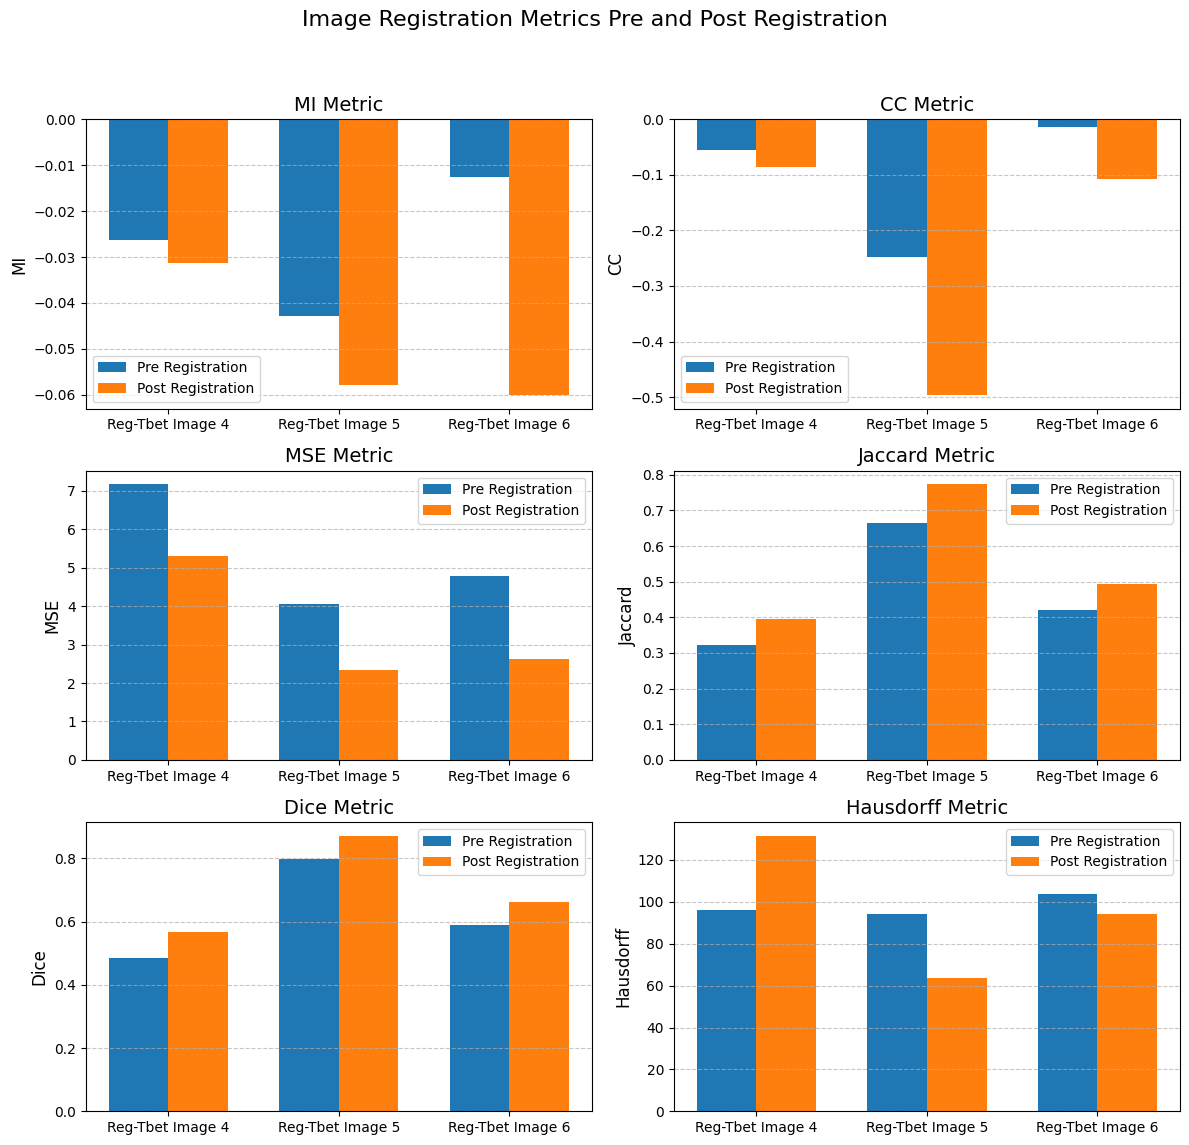

In [56]:
#Create a separate graph for each metric. Each graph should have 2 bars, one for pre registration and one for post registration
# Create a figure with subplots
fig_1, axes_1 = plt.subplots(3, 2, figsize=(12, 12))
# Set the figure title
fig_1.suptitle('Image Registration Metrics Pre and Post Registration', fontsize=16)
# Set the bar width
bar_width_1 = 0.35
# Set the bar positions
bar_positions_1 = np.arange(len(metrics_df_1['Sample']))
# Set the colors for the bars
colors_1 = ['#1f77b4', '#ff7f0e']  # Blue and Orange
# Set the bar labels
bar_labels_1 = ['Pre Registration', 'Post Registration']
# Set the metrics to plot
metrics_to_plot_1 = ['MI', 'CC', 'MSE', 'Jaccard', 'Dice', 'Hausdorff']
# Loop through each metric and create a bar plot

for i, metric in enumerate(metrics_to_plot_1):
    # Create a bar plot for the metric
    axes_1[i // 2, i % 2].bar(bar_positions_1 - bar_width_1/2, metrics_df_1[f'{metric}_pre'], width=bar_width_1, label='Pre Registration', color=colors_1[0])
    axes_1[i // 2, i % 2].bar(bar_positions_1 + bar_width_1/2, metrics_df_1[f'{metric}_post'], width=bar_width_1, label='Post Registration', color=colors_1[1])
    
    # Set the x-ticks and labels
    axes_1[i // 2, i % 2].set_xticks(bar_positions_1)
    axes_1[i // 2, i % 2].set_xticklabels(metrics_df_1['Sample'])
    
    # Set the title and labels
    axes_1[i // 2, i % 2].set_title(f'{metric} Metric', fontsize=14)
    axes_1[i // 2, i % 2].set_ylabel(metric, fontsize=12)
    axes_1[i // 2, i % 2].legend()
    # Set grid lines
    axes_1[i // 2, i % 2].grid(axis='y', linestyle='--', alpha=0.7)
    
# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [58]:
#Convert each set of corresponding tissue slices into a DataFrame

#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels

#Each different row represents a different tissue


merged_df_2 = pd.concat([row_1, row_2, row_3], ignore_index=True)

#Add columns to the merged DataFrame
merged_df_2['scale'] = [7,7,7]
merged_df_2['final_image_parameters'] = [fwd_aff_4.parameters,fwd_aff_5.parameters,fwd_aff_6.parameters]
merged_df_2['final_image_fixed_parameters'] = [fwd_aff_4.fixed_parameters,fwd_aff_5.fixed_parameters,fwd_aff_6.fixed_parameters]
merged_df_2['final_image_parameters'] = [fwd_aff_4.parameters,fwd_aff_5.parameters,fwd_aff_6.parameters]

merged_df_2

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_parameters,final_image_fixed_parameters
0,101,709.0,834.0,L1_2,LY1,AP0140001,7,"[0.942355215549469, -0.334614098072052, 0.3346...","[41.98567581176758, 35.215389251708984]"
1,107,710.0,835.0,L2_4,LY2,AP0140002,7,"[0.914401650428772, 0.27236711978912354, -0.31...","[52.78548049926758, 42.120697021484375]"
2,535,712.0,837.0,L4_3,LY4,AP0140004,7,"[0.9255388975143433, 0.2976766526699066, -0.36...","[50.77205276489258, 28.47519302368164]"


In [59]:
#Save the merged DataFrame to a CSV file
merged_df_2.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_7.csv', index=False)

## Affine Registration (Scale 5)

### Load in spatial data

In [60]:
#Loop through each image in sp.images and crop it
cropped_images_3 = {}
for sampleid in sp.images:
    cropped_images_3[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=5)[0]


#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 times
panel_3 = ['regression','tbet']*3
panel_df_3 = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframw
cropped_images_dimensions_3 = {}
for sampleid, cropped_image in cropped_images_3.items():
    cropped_images_dimensions_3[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }


#Convert to dataframe
cropped_images_dimensions_df_3 = pd.DataFrame.from_dict(cropped_images_dimensions_3, orient='index')


#Add the panel column to the cropped images dimensions dataframe
cropped_images_dimensions_df_3['panel'] = panel_df_3['panel'].values

#View dimensions of the cropped images
cropped_images_dimensions_df_3


,dimensions,data_type,coordinates,panel
sampleid_709_image,"(2048, 1536)",float32,"[c, y, x]",regression
sampleid_834_image,"(1536, 2048)",float32,"[c, y, x]",tbet
sampleid_710_image,"(2048, 1536)",float32,"[c, y, x]",regression
sampleid_835_image,"(1536, 2048)",float32,"[c, y, x]",tbet
sampleid_712_image,"(2048, 1536)",float32,"[c, y, x]",regression
sampleid_837_image,"(1536, 2048)",float32,"[c, y, x]",tbet


In [61]:
#Convert the cropped images to ants
reg_image_cropped_ants_7 = ants.from_numpy(cropped_images_3[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_7 = ants.from_numpy(cropped_images_3[f'sampleid_{results[0]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_8 = ants.from_numpy(cropped_images_3[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_8 = ants.from_numpy(cropped_images_3[f'sampleid_{results[1]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_9 = ants.from_numpy(cropped_images_3[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_9 = ants.from_numpy(cropped_images_3[f'sampleid_{results[2]["tbet_sampleid"]}_image'].compute().data)


### Pad Images

In [62]:
#Pad the images so they are the same size
reg_image_cropped_shape_7 = reg_image_cropped_ants_7.shape
tbet_image_cropped_shape_7= tbet_image_cropped_ants_7.shape

reg_image_cropped_shape_8 = reg_image_cropped_ants_8.shape
tbet_image_cropped_shape_8= tbet_image_cropped_ants_8.shape

reg_image_cropped_shape_9 = reg_image_cropped_ants_9.shape
tbet_image_cropped_shape_9= tbet_image_cropped_ants_9.shape

#Get the target shapes for padding
target_shape_7_x = max(reg_image_cropped_shape_7[0],tbet_image_cropped_shape_7[0])
target_shape_7_y = max(reg_image_cropped_shape_7[1],tbet_image_cropped_shape_7[1])

target_shape_8_x = max(reg_image_cropped_shape_8[0],tbet_image_cropped_shape_8[0])
target_shape_8_y = max(reg_image_cropped_shape_8[1],tbet_image_cropped_shape_8[1])

target_shape_9_x = max(reg_image_cropped_shape_9[0],tbet_image_cropped_shape_9[0])
target_shape_9_y = max(reg_image_cropped_shape_9[1],tbet_image_cropped_shape_9[1])

#Calculate the padding
pad_reg_X_7 = (0,target_shape_7_x-reg_image_cropped_shape_7[0])
pad_reg_Y_7 = (0,target_shape_7_y-reg_image_cropped_shape_7[1])

pad_reg_X_8 = (0,target_shape_8_x-reg_image_cropped_shape_8[0])
pad_reg_Y_8 = (0,target_shape_8_y-reg_image_cropped_shape_8[1])

pad_reg_X_9 = (0,target_shape_9_x-reg_image_cropped_shape_9[0])
pad_reg_Y_9 = (0,target_shape_9_y-reg_image_cropped_shape_9[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_7_padded = ants.pad_image(reg_image_cropped_ants_7, (target_shape_7_x,target_shape_7_y))
reg_image_cropped_ants_8_padded = ants.pad_image(reg_image_cropped_ants_8, (target_shape_8_x,target_shape_8_y))
reg_image_cropped_ants_9_padded = ants.pad_image(reg_image_cropped_ants_9, (target_shape_9_x,target_shape_9_y))

# Pad the tbet images to match the size of the rigid transformed images
tbet_image_cropped_ants_7_padded = ants.pad_image(tbet_image_cropped_ants_7, (target_shape_7_x,target_shape_7_y))
tbet_image_cropped_ants_8_padded = ants.pad_image(tbet_image_cropped_ants_8, (target_shape_8_x,target_shape_8_y))
tbet_image_cropped_ants_9_padded = ants.pad_image(tbet_image_cropped_ants_9, (target_shape_9_x,target_shape_9_y))

# Print the shapes of the padded images
print("Padded regression image shape 7: ", reg_image_cropped_ants_7_padded.shape)   
print("Padded regression image shape 8: ", reg_image_cropped_ants_8_padded.shape)
print("Padded regression image shape 9: ", reg_image_cropped_ants_9_padded.shape,"\n")

print("Padded tbet image shape 7: ", tbet_image_cropped_ants_7_padded.shape)
print("Padded tbet image shape 8: ", tbet_image_cropped_ants_8_padded.shape)
print("Padded tbet image shape 9: ", tbet_image_cropped_ants_9_padded.shape,"\n")


Padded regression image shape 7:  (2048, 2048)
Padded regression image shape 8:  (2048, 2048)
Padded regression image shape 9:  (2048, 2048) 

Padded tbet image shape 7:  (2048, 2048)
Padded tbet image shape 8:  (2048, 2048)
Padded tbet image shape 9:  (2048, 2048) 



### Scale and apply registration parameters at lower resolution to higher resolution image

In [63]:
# Compute scaling factors
scaling_factor_4 = compute_scaling_factor(sp.images[f'{reg_name_1}']['scale5'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_1}']['scale7'].image.transform['scale0'].scale[0])
scaling_factor_5 = compute_scaling_factor(sp.images[f'{reg_name_2}']['scale5'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_2}']['scale7'].image.transform['scale0'].scale[0])
scaling_factor_6 = compute_scaling_factor(sp.images[f'{reg_name_3}']['scale5'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_3}']['scale7'].image.transform['scale0'].scale[0])

### ANTS Affine transform

In [64]:
#Apply the scaling factors to the transformations
scaled_transform_7_mat = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image4_0GenericAffine.mat',
    scaling_factor_4
)

# Perform affine registration first on the image
affine_result_7 = ants.registration(
    fixed=reg_image_cropped_ants_7_padded,
    moving=tbet_image_cropped_ants_7_padded,
    initial_transform=scaled_transform_7_mat,
    type_of_transform='Affine',
    aff_metric='Mattes',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_'
)

#Apply the rigid transformation to the first moving image
affine_transformed_image_7 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_7_padded,
    moving=tbet_image_cropped_ants_7_padded,
    transformlist=affine_result_7['fwdtransforms']
)

# Apply the scaling factors to the transformations
scaled_transform_8_mat = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image5_0GenericAffine.mat',
    scaling_factor_5
)

# Perform affine registration first on the eigith image
affine_result_8 = ants.registration(
    fixed=reg_image_cropped_ants_8_padded,
    moving=tbet_image_cropped_ants_8_padded,
    initial_transform=scaled_transform_8_mat,
    type_of_transform='Affine',
    aff_metric='Mattes',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_'
)

#Apply the rigid transformation to the second moving image
affine_transformed_image_8 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_8_padded,
    moving=tbet_image_cropped_ants_8_padded,
    transformlist=affine_result_8['fwdtransforms']
)

# Apply the scaling factors to the transformations
scaled_transform_9_mat = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image6_0GenericAffine.mat',
    scaling_factor_6
)

# Perform affine registration first on the image
affine_result_9 = ants.registration(
    fixed=reg_image_cropped_ants_9_padded,
    moving=tbet_image_cropped_ants_9_padded,
    initial_transform=scaled_transform_9_mat,
    type_of_transform='Affine',
    aff_metric='Mattes',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_'
)

#Apply the rigid transformation to the third moving image
affine_transformed_image_9 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_9_padded,
    moving=tbet_image_cropped_ants_9_padded,
    transformlist=affine_result_9['fwdtransforms']
)

antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_rigid_registration_image4_0GenericAffine_scaled.mat -m Mattes[000001BF9B5D54E8,000001BF9B5D51A8,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image7_,000001BF9B5D5448,000001BF9B5D5308] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_rigid_registration_image5_0GenericAffine_scaled.mat -m Mattes[000001BF9B5D51A8,000001BF885CA8A8,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image8_,000001BF9B5D5388,000001BF9B5D5328] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_rigid_registration_image6_0GenericAffine_scaled.mat -m Mattes[000001BF9B5D51A8,000001BF9B5D5448,1,32,re

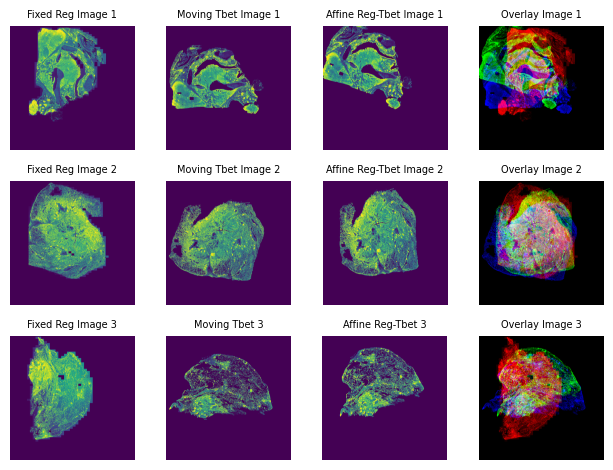

In [65]:
#Visualize the results

plt.subplot(3,4,1)
fixed_7 = exposure.equalize_hist(reg_image_cropped_ants_7_padded.numpy())
plt.imshow(fixed_7)
plt.title('Fixed Reg Image 1',fontsize=7)
plt.axis('off') 

plt.subplot(3,4,2)
moving_7 = exposure.equalize_hist(tbet_image_cropped_ants_7_padded.numpy())
plt.imshow(moving_7)
plt.title('Moving Tbet Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_7 = exposure.equalize_hist(affine_transformed_image_7.numpy())
plt.imshow(registered_7)
plt.title('Affine Reg-Tbet Image 1',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_7_normalized = (fixed_7 - fixed_7.min()) / (fixed_7.max() - fixed_7.min())
registered_7_normalized = (registered_7 - registered_7.min()) / (registered_7.max() - registered_7.min())
moving_7_normalized = (moving_7 - moving_7.min()) / (moving_7.max() - moving_7.min())

#Overlay for the first image
plt.subplot(3, 4, 4)
overlay_7 = np.stack([fixed_7_normalized, registered_7_normalized, moving_7_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_7)
plt.title('Overlay Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_8 = exposure.equalize_hist(reg_image_cropped_ants_8_padded.numpy())
plt.imshow(fixed_8)
plt.title('Fixed Reg Image 2',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_8 = exposure.equalize_hist(tbet_image_cropped_ants_8_padded.numpy())
plt.imshow(moving_8)
plt.title('Moving Tbet Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_8 = exposure.equalize_hist(affine_transformed_image_8.numpy())
plt.imshow(registered_8)
plt.title('Affine Reg-Tbet Image 2',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_8_normalized = (fixed_8 - fixed_8.min()) / (fixed_8.max() - fixed_8.min())
registered_8_normalized = (registered_8 - registered_8.min()) / (registered_8.max() - registered_8.min())
moving_8_normalized = (moving_8 - moving_8.min()) / (moving_8.max() - moving_8.min())

#Overlay for the second image
plt.subplot(3, 4, 8)
overlay_8 = np.stack([fixed_8_normalized, registered_8_normalized, moving_8_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_8)
plt.title('Overlay Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
fixed_9 = exposure.equalize_hist(reg_image_cropped_ants_9_padded.numpy())
plt.imshow(fixed_9)
plt.title('Fixed Reg Image 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
moving_9 = exposure.equalize_hist(tbet_image_cropped_ants_9_padded.numpy())
plt.imshow(moving_9)
plt.title('Moving Tbet 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
registered_9 = exposure.equalize_hist(affine_transformed_image_9.numpy())
plt.imshow(registered_9)
plt.title('Affine Reg-Tbet 3',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_9_normalized = (fixed_9 - fixed_9.min()) / (fixed_9.max() - fixed_9.min())
registered_9_normalized = (registered_9 - registered_9.min()) / (registered_9.max() - registered_9.min())
moving_9_normalized = (moving_9 - moving_9.min()) / (moving_9.max() - moving_9.min())

#Overlay for the third image
plt.subplot(3,4,12)
overlay_9 = np.stack([fixed_9_normalized, registered_9_normalized, moving_9_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_9)
plt.title('Overlay Image 3', fontsize=7)
plt.axis('off')
plt.tight_layout()
plt.show()



In [66]:
#View image metadata
affine_result_7

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -256.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-256.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine.mat']}

In [67]:
#Get transform parameters
fwd_aff_7 = ants.read_transform(affine_result_7['fwdtransforms'][0])
fwd_aff_7.parameters

array([  0.93112254,  -0.33095813,   0.34083274,   0.95464003,
       205.60545349, 120.79027557])

In [68]:
fwd_aff_7.fixed_parameters

array([41.98567581, 35.21538925])

In [69]:
#View image metadata
affine_result_8

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -256.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-256.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_0GenericAffine.mat']}

In [70]:
#Get transform parameters
fwd_aff_8 = ants.read_transform(affine_result_8['fwdtransforms'][0])
fwd_aff_8.parameters

array([ 8.95799041e-01,  2.54559726e-01, -3.32973301e-01,  1.08069909e+00,
       -2.32448792e+02,  4.30548309e+02])

In [71]:
fwd_aff_8.fixed_parameters

array([52.7854805 , 42.12069702])

In [72]:
#View image metadata
affine_result_9

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -256.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-256.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_0GenericAffine.mat']}

In [73]:
#Get transform parameters
fwd_aff_9 = ants.read_transform(affine_result_9['fwdtransforms'][0])
fwd_aff_9.parameters

array([ 9.26966131e-01,  2.96448678e-01, -3.62370223e-01,  1.11024559e+00,
       -2.79104828e+02,  4.73998383e+02])

In [74]:
fwd_aff_9.fixed_parameters

array([50.77205276, 28.47519302])

### Metrics

In [75]:
#Compute mutual information between the fixed regression and  transformed reg-tbet image pre/post registration
mi7_pre = ants.image_mutual_information(reg_image_cropped_ants_7_padded, tbet_image_cropped_ants_7_padded)
mi8_pre = ants.image_mutual_information(reg_image_cropped_ants_8_padded, tbet_image_cropped_ants_8_padded)
mi9_pre = ants.image_mutual_information(reg_image_cropped_ants_9_padded, tbet_image_cropped_ants_9_padded)

mi7_post = ants.image_mutual_information(reg_image_cropped_ants_7_padded, affine_transformed_image_7)
mi8_post = ants.image_mutual_information(reg_image_cropped_ants_8_padded, affine_transformed_image_8)
mi9_post = ants.image_mutual_information(reg_image_cropped_ants_9_padded, affine_transformed_image_9)

#Compute normalized cross correlation between the fixed regression and  transformed reg-tbet image pre/post registration
cc7_pre = ants.math.image_similarity(reg_image_cropped_ants_7_padded,tbet_image_cropped_ants_7_padded, 'Correlation')
cc8_pre = ants.math.image_similarity(reg_image_cropped_ants_8_padded, tbet_image_cropped_ants_8_padded, 'Correlation')
cc9_pre = ants.math.image_similarity(reg_image_cropped_ants_9_padded, tbet_image_cropped_ants_9_padded, 'Correlation')

cc7_post = ants.math.image_similarity(reg_image_cropped_ants_7_padded, affine_transformed_image_7, 'Correlation')
cc8_post = ants.math.image_similarity(reg_image_cropped_ants_8_padded, affine_transformed_image_8, 'Correlation')
cc9_post  = ants.math.image_similarity(reg_image_cropped_ants_9_padded, affine_transformed_image_9, 'Correlation')

#Compute mean squares between the fixed regression and  transformed axis-reg image reg-tbet registration
mse7_pre = ants.math.image_similarity(reg_image_cropped_ants_7_padded,tbet_image_cropped_ants_7_padded, 'MeanSquares')
mse8_pre = ants.math.image_similarity(reg_image_cropped_ants_8_padded, tbet_image_cropped_ants_8_padded, 'MeanSquares')
mse9_pre = ants.math.image_similarity(reg_image_cropped_ants_9_padded, tbet_image_cropped_ants_9_padded, 'MeanSquares')

mse7_post = ants.math.image_similarity(reg_image_cropped_ants_7_padded, affine_transformed_image_7, 'MeanSquares')
mse8_post = ants.math.image_similarity(reg_image_cropped_ants_8_padded, affine_transformed_image_8, 'MeanSquares')
mse9_post = ants.math.image_similarity(reg_image_cropped_ants_9_padded, affine_transformed_image_9, 'MeanSquares')


In [76]:
# Binarize the arrays (threshold = 0.5) to create binary masks
reg_image_cropped_ants_7_binary = (reg_image_cropped_ants_7_padded.numpy() > 0.5).astype(int)
reg_image_cropped_ants_8_binary = (reg_image_cropped_ants_8_padded.numpy() > 0.5).astype(int)
reg_image_cropped_ants_9_binary = (reg_image_cropped_ants_9_padded.numpy() > 0.5).astype(int)

tbet_image_cropped_ants_7_binary = (tbet_image_cropped_ants_7_padded.numpy() > 0.5).astype(int)
tbet_image_cropped_ants_8_binary = (tbet_image_cropped_ants_8_padded.numpy() > 0.5).astype(int)
tbet_image_cropped_ants_9_binary = (tbet_image_cropped_ants_9_padded.numpy() > 0.5).astype(int)

affine_result_7_binary = (affine_transformed_image_7.numpy() > 0.5).astype(int)
affine_result_8_binary = (affine_transformed_image_8.numpy() > 0.5).astype(int)
affine_result_9_binary = (affine_transformed_image_9.numpy() > 0.5).astype(int)

In [77]:
# Compute Jaccard Index pre/post registration

jaccard_7_pre = jaccard_score(reg_image_cropped_ants_7_binary.flatten(), tbet_image_cropped_ants_7_binary.flatten())
jaccard_8_pre = jaccard_score(reg_image_cropped_ants_8_binary.flatten(), tbet_image_cropped_ants_8_binary.flatten())
jaccard_9_pre = jaccard_score(reg_image_cropped_ants_9_binary.flatten(), tbet_image_cropped_ants_9_binary.flatten())

jaccard_7_post = jaccard_score(reg_image_cropped_ants_7_binary.flatten(), affine_result_7_binary.flatten())
jaccard_8_post = jaccard_score(reg_image_cropped_ants_8_binary.flatten(), affine_result_8_binary.flatten())
jaccard_9_post = jaccard_score(reg_image_cropped_ants_9_binary.flatten(), affine_result_9_binary.flatten())

# Compute Dice Similarity Score pre/post registration   
dice7_pre = f1_score(reg_image_cropped_ants_7_binary.flatten(), tbet_image_cropped_ants_7_binary.flatten())
dice8_pre = f1_score(reg_image_cropped_ants_8_binary.flatten(), tbet_image_cropped_ants_8_binary.flatten())
dice9_pre = f1_score(reg_image_cropped_ants_9_binary.flatten(), tbet_image_cropped_ants_9_binary.flatten())

dice7_post = f1_score(reg_image_cropped_ants_7_binary.flatten(), affine_result_7_binary.flatten())
dice8_post = f1_score(reg_image_cropped_ants_8_binary.flatten(), affine_result_8_binary.flatten())
dice9_post = f1_score(reg_image_cropped_ants_9_binary.flatten(), affine_result_9_binary.flatten())

In [78]:

# Convert the images to SimpleITK format

sitk_initial_image_7 = sitk.GetImageFromArray(reg_image_cropped_ants_7_padded.numpy())
sitk_moving_image_7 = sitk.GetImageFromArray(tbet_image_cropped_ants_7_padded.numpy())
sitk_final_image_7 = sitk.GetImageFromArray(affine_transformed_image_7.numpy())

sitk_initial_image_8 = sitk.GetImageFromArray(reg_image_cropped_ants_8_padded.numpy())
sitk_moving_image_8 = sitk.GetImageFromArray(tbet_image_cropped_ants_8_padded.numpy())
sitk_final_image_8 = sitk.GetImageFromArray(affine_transformed_image_8.numpy())

sitk_initial_image_9 = sitk.GetImageFromArray(reg_image_cropped_ants_9_padded.numpy())
sitk_moving_image_9 = sitk.GetImageFromArray(tbet_image_cropped_ants_9_padded.numpy())
sitk_final_image_9 = sitk.GetImageFromArray(affine_transformed_image_9.numpy())

# Compute Hausdorff Distance using SimpleITK pre/post registration
hausdorff_filter_7_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_7_pre.Execute(sitk_initial_image_7, sitk_moving_image_7)
hausdorff_sitk_7_pre = hausdorff_filter_7_pre.GetHausdorffDistance()

hausdorff_filter_7_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_7_post.Execute(sitk_initial_image_7, sitk_final_image_7)
hausdorff_sitk_7_post = hausdorff_filter_7_post.GetHausdorffDistance()

hausdorff_filter_8_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_8_pre.Execute(sitk_initial_image_8, sitk_moving_image_8)
hausdorff_sitk_8_pre = hausdorff_filter_8_pre.GetHausdorffDistance()

hausdorff_filter_8_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_8_post.Execute(sitk_initial_image_8, sitk_final_image_8)
hausdorff_sitk_8_post = hausdorff_filter_8_post.GetHausdorffDistance()

hausdorff_filter_9_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_9_pre.Execute(sitk_initial_image_9, sitk_moving_image_9)
hausdorff_sitk_9_pre = hausdorff_filter_9_pre.GetHausdorffDistance()

hausdorff_filter_9_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_9_post.Execute(sitk_initial_image_9, sitk_final_image_9)
hausdorff_sitk_9_post = hausdorff_filter_9_post.GetHausdorffDistance()


In [79]:
#Display the mi, cc, mse, jaccard, dice and hausdorff distance as graphs
metrics_df_3 = pd.DataFrame({
    'Sample': ['Reg-Tbet Image 7', 'Reg-Tbet Image 8', 'Reg-Tbet Image 9'],
    'MI_pre': [mi7_pre, mi8_pre, mi9_pre],
    'MI_post': [mi7_post, mi8_post, mi9_post],
    'CC_pre': [cc7_pre, cc8_pre, cc9_pre],
    'CC_post': [cc7_post, cc8_post, cc9_post],
    'MSE_pre': [mse7_pre, mse8_pre, mse9_pre],
    'MSE_post': [mse7_post, mse8_post, mse9_post],
    'Jaccard_pre': [jaccard_7_pre, jaccard_8_pre, jaccard_9_pre],
    'Jaccard_post': [jaccard_7_post, jaccard_8_post, jaccard_9_post],
    'Dice_pre': [dice7_pre, dice8_pre, dice9_pre],
    'Dice_post': [dice7_post, dice8_post, dice9_post],
    'Hausdorff_pre': [hausdorff_sitk_7_pre, hausdorff_sitk_8_pre, hausdorff_sitk_9_pre],
    'Hausdorff_post': [hausdorff_sitk_7_post, hausdorff_sitk_8_post, hausdorff_sitk_9_post]
})

metrics_df_3

,Sample,MI_pre,MI_post,CC_pre,CC_post,MSE_pre,MSE_post,Jaccard_pre,Jaccard_post,Dice_pre,Dice_post,Hausdorff_pre,Hausdorff_post
0,Reg-Tbet Image 7,-0.013779,-0.017879,-0.039932,-0.062746,8.786033,6.270464,0.288394,0.365855,0.447680,0.535715,384.610192,488.594924
1,Reg-Tbet Image 8,-0.012638,-0.023624,-0.160144,-0.362923,5.616770,3.184996,0.599419,0.724079,0.749546,0.839960,373.128664,257.287777
2,Reg-Tbet Image 9,-0.001635,-0.012077,-0.006733,-0.060345,7.311054,4.064605,0.278154,0.361555,0.435243,0.531092,413.353360,408.178882


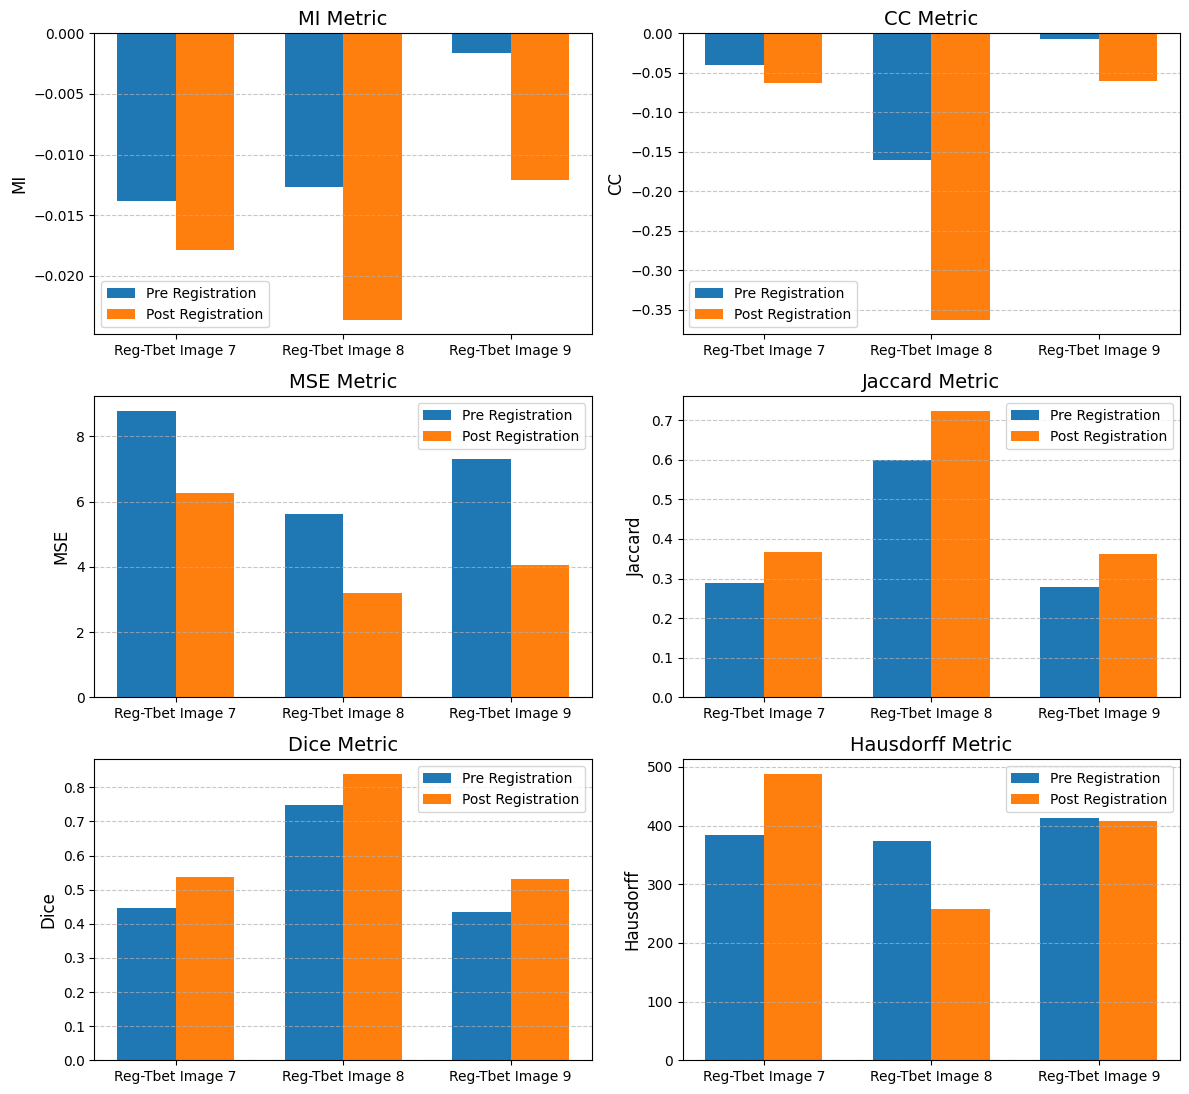

In [80]:
#Create a separate graph for each metric. Each graph should have 2 bars, one for pre registration and one for post registration
# Create a figure with subplots
fig_2, axes_2 = plt.subplots(3, 2, figsize=(12, 12))
# Set the figure title
fig_1.suptitle('Image Registration Metrics Pre and Post Registration', fontsize=16)
# Set the bar width
bar_width_2 = 0.35
# Set the bar positions
bar_positions_2 = np.arange(len(metrics_df_3['Sample']))
# Set the colors for the bars
colors_2 = ['#1f77b4', '#ff7f0e']  # Blue and Orange
# Set the bar labels
bar_labels_2 = ['Pre Registration', 'Post Registration']
# Set the metrics to plot
metrics_to_plot_2= ['MI', 'CC', 'MSE', 'Jaccard', 'Dice', 'Hausdorff']
# Loop through each metric and create a bar plot

for i, metric in enumerate(metrics_to_plot_2):
    # Create a bar plot for the metric
    axes_2[i // 2, i % 2].bar(bar_positions_2 - bar_width_2/2, metrics_df_3[f'{metric}_pre'], width=bar_width_2, label='Pre Registration', color=colors_2[0])
    axes_2[i // 2, i % 2].bar(bar_positions_2 + bar_width_2/2, metrics_df_3[f'{metric}_post'], width=bar_width_2, label='Post Registration', color=colors_2[1])

    # Set the x-ticks and labels
    axes_2[i // 2, i % 2].set_xticks(bar_positions_2)
    axes_2[i // 2, i % 2].set_xticklabels(metrics_df_3['Sample'])
    # Set the title and labels
    axes_2[i // 2, i % 2].set_title(f'{metric} Metric', fontsize=14)
    axes_2[i // 2, i % 2].set_ylabel(metric, fontsize=12)
    axes_2[i // 2, i % 2].legend()
    # Set grid lines
    axes_2[i // 2, i % 2].grid(axis='y', linestyle='--', alpha=0.7)
    
# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [81]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels
#Each different row represents a different tissue

merged_df_3 = pd.concat([row_1, row_2, row_3], ignore_index=True)
#Add columns to the merged DataFrame
merged_df_3['scale'] = [5,5,5]
merged_df_3['final_image_parameters'] = [fwd_aff_7.parameters,fwd_aff_8.parameters,fwd_aff_9.parameters]
merged_df_3['final_image_fixed_parameters'] = [fwd_aff_7.fixed_parameters,fwd_aff_8.fixed_parameters,fwd_aff_9.fixed_parameters]
merged_df_3

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_parameters,final_image_fixed_parameters
0,101,709.0,834.0,L1_2,LY1,AP0140001,5,"[0.9311225414276123, -0.33095812797546387, 0.3...","[41.98567581176758, 35.215389251708984]"
1,107,710.0,835.0,L2_4,LY2,AP0140002,5,"[0.8957990407943726, 0.254559725522995, -0.332...","[52.78548049926758, 42.120697021484375]"
2,535,712.0,837.0,L4_3,LY4,AP0140004,5,"[0.92696613073349, 0.296448677778244, -0.36237...","[50.77205276489258, 28.47519302368164]"


In [82]:
merged_df_3.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_5.csv', index=False)

## Affine Registration (Scale 3)

### Load in spatial data

In [83]:
#Loop through each image in sp.images and crop it
cropped_images_4 = {}
for sampleid in sp.images:
    cropped_images_4[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=3)[0]


#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time
panel_4 = ['regression','tbet']*3
panel_df_4 = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframe
cropped_images_dimensions_4 = {}
for sampleid, cropped_image in cropped_images_4.items():
    cropped_images_dimensions_4[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }

cropped_images_dimensions_df_4 = pd.DataFrame.from_dict(cropped_images_dimensions_4, orient='index')
#Add the panel column to the cropped images dimensions dataframe
cropped_images_dimensions_df_4['panel'] = panel_df_4['panel'].values
cropped_images_dimensions_df_4



,dimensions,data_type,coordinates,panel
sampleid_709_image,"(8192, 6144)",float32,"[c, y, x]",regression
sampleid_834_image,"(6144, 8192)",float32,"[c, y, x]",tbet
sampleid_710_image,"(8192, 6144)",float32,"[c, y, x]",regression
sampleid_835_image,"(6144, 8192)",float32,"[c, y, x]",tbet
sampleid_712_image,"(8192, 6144)",float32,"[c, y, x]",regression
sampleid_837_image,"(6144, 8192)",float32,"[c, y, x]",tbet


In [84]:
#Cronvert the cropped images to ants
reg_image_cropped_ants_10 = ants.from_numpy(cropped_images_4[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_10 = ants.from_numpy(cropped_images_4[f'sampleid_{results[0]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_11 = ants.from_numpy(cropped_images_4[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_11 = ants.from_numpy(cropped_images_4[f'sampleid_{results[1]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_12 = ants.from_numpy(cropped_images_4[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_12 = ants.from_numpy(cropped_images_4[f'sampleid_{results[2]["tbet_sampleid"]}_image'].compute().data)


### Pad Images

In [85]:
#Pad the images so they are the same size
reg_image_cropped_shape_10 = reg_image_cropped_ants_10.shape
tbet_image_cropped_shape_10= tbet_image_cropped_ants_10.shape

reg_image_cropped_shape_11 = reg_image_cropped_ants_11.shape
tbet_image_cropped_shape_11= tbet_image_cropped_ants_11.shape

reg_image_cropped_shape_12 = reg_image_cropped_ants_12.shape
tbet_image_cropped_shape_12= tbet_image_cropped_ants_12.shape

#Get the target shapes for padding
target_shape_10_x = max(reg_image_cropped_shape_10[0],tbet_image_cropped_shape_10[0])
target_shape_10_y = max(reg_image_cropped_shape_10[1],tbet_image_cropped_shape_10[1])

target_shape_11_x = max(reg_image_cropped_shape_11[0],tbet_image_cropped_shape_11[0])
target_shape_11_y = max(reg_image_cropped_shape_11[1],tbet_image_cropped_shape_11[1])

target_shape_12_x = max(reg_image_cropped_shape_12[0],tbet_image_cropped_shape_12[0])
target_shape_12_y = max(reg_image_cropped_shape_12[1],tbet_image_cropped_shape_12[1])

#Calculate the padding
pad_reg_X_10 = (0,target_shape_10_x-reg_image_cropped_shape_10[0])
pad_reg_Y_10 = (0,target_shape_10_y-reg_image_cropped_shape_10[1])

pad_reg_X_11 = (0,target_shape_11_x-reg_image_cropped_shape_11[0])
pad_reg_Y_11 = (0,target_shape_11_y-reg_image_cropped_shape_11[1])

pad_reg_X_12 = (0,target_shape_12_x-reg_image_cropped_shape_12[0])
pad_reg_Y_12 = (0,target_shape_12_y-reg_image_cropped_shape_12[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_10_padded = ants.pad_image(reg_image_cropped_ants_10, (target_shape_10_x,target_shape_10_y))
reg_image_cropped_ants_11_padded = ants.pad_image(reg_image_cropped_ants_11, (target_shape_11_x,target_shape_11_y))
reg_image_cropped_ants_12_padded = ants.pad_image(reg_image_cropped_ants_12, (target_shape_12_x,target_shape_12_y))

# Pad the tbet images to match the size of the rigid transformed images
tbet_image_cropped_ants_10_padded = ants.pad_image(tbet_image_cropped_ants_10, (target_shape_10_x,target_shape_10_y))
tbet_image_cropped_ants_11_padded = ants.pad_image(tbet_image_cropped_ants_11, (target_shape_11_x,target_shape_11_y))
tbet_image_cropped_ants_12_padded = ants.pad_image(tbet_image_cropped_ants_12, (target_shape_12_x,target_shape_12_y))

# Print the shapes of the padded images
print("Padded regression image shape 10: ", reg_image_cropped_ants_10_padded.shape)
print("Padded regression image shape 11: ", reg_image_cropped_ants_11_padded.shape)
print("Padded regression image shape 12: ", reg_image_cropped_ants_12_padded.shape,"\n")

print("Padded tbet image shape 10: ", tbet_image_cropped_ants_10_padded.shape)
print("Padded tbet image shape 11: ", tbet_image_cropped_ants_11_padded.shape)
print("Padded tbet image shape 12: ", tbet_image_cropped_ants_12_padded.shape,"\n")

Padded regression image shape 10:  (8192, 8192)
Padded regression image shape 11:  (8192, 8192)
Padded regression image shape 12:  (8192, 8192) 

Padded tbet image shape 10:  (8192, 8192)
Padded tbet image shape 11:  (8192, 8192)
Padded tbet image shape 12:  (8192, 8192) 



### Scale and apply registration parameters at lower resolution to higher resolution image

In [86]:
# Compute scaling factors
scaling_factor_7 = compute_scaling_factor(sp.images[f'{reg_name_1}']['scale3'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_1}']['scale5'].image.transform['scale0'].scale[0]) 
scaling_factor_8 = compute_scaling_factor(sp.images[f'{reg_name_2}']['scale3'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_2}']['scale5'].image.transform['scale0'].scale[0])
scaling_factor_9 = compute_scaling_factor(sp.images[f'{reg_name_3}']['scale3'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_3}']['scale5'].image.transform['scale0'].scale[0])

### ANTS Affine transform

In [89]:
#Apply the scaling factors to the transformations

scaled_transform_10_mat = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine.mat',
    scaling_factor_7
)


# Perform affine registration first on the image
affine_result_10 = ants.registration(
    fixed=reg_image_cropped_ants_10_padded,
    moving=tbet_image_cropped_ants_10_padded,
    initial_transform=scaled_transform_10_mat,
    type_of_transform='Affine',
    aff_metric='Mattes',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image10_'
)

#Apply the rigid transformation to the first moving image
affine_transformed_image_10 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_10_padded,
    moving=tbet_image_cropped_ants_10_padded,
    transformlist=affine_result_10['fwdtransforms']
)

# Apply the scaling factors to the transformations
scaled_transform_11_mat = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_0GenericAffine.mat',
    scaling_factor_8
)

# Perform affine registration first on the image
affine_result_11 = ants.registration(
    fixed=reg_image_cropped_ants_11_padded,
    moving=tbet_image_cropped_ants_11_padded,
    initial_transform=scaled_transform_11_mat,
    type_of_transform='Affine',
    aff_metric='Mattes',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image11_'
)

#Apply the rigid transformation to the second moving image
affine_transformed_image_11 = ants.apply_transforms(    
    fixed=reg_image_cropped_ants_11_padded,
    moving=tbet_image_cropped_ants_11_padded,
    transformlist=affine_result_11['fwdtransforms']
)

# Apply the scaling factors to the transformations
scaled_transform_12_mat = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_0GenericAffine.mat',
    scaling_factor_9
)

# Perform affine registration first on the image
affine_result_12 = ants.registration(
    fixed=reg_image_cropped_ants_12_padded,
    moving=tbet_image_cropped_ants_12_padded,
    initial_transform=scaled_transform_12_mat,
    type_of_transform='Affine',
    aff_metric='Mattes',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image12_'
)

#Apply the rigid transformation to the third moving image
affine_transformed_image_12 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_12_padded,
    moving=tbet_image_cropped_ants_12_padded,
    transformlist=affine_result_12['fwdtransforms']
)

antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image7_0GenericAffine_scaled.mat -m Mattes[000001BF8670E7A8,000001BF9D06B208,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image10_,000001BFB86ECC28,000001BFB872D108] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image8_0GenericAffine_scaled.mat -m Mattes[000001BFB872D108,000001BFB86C9CC8,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image11_,000001BF9D06B208,000001BFB872E6E8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image9_0GenericAffine_scaled.mat -m Mattes[000001BF9D06B088,000001BF9D06B1C8,1,

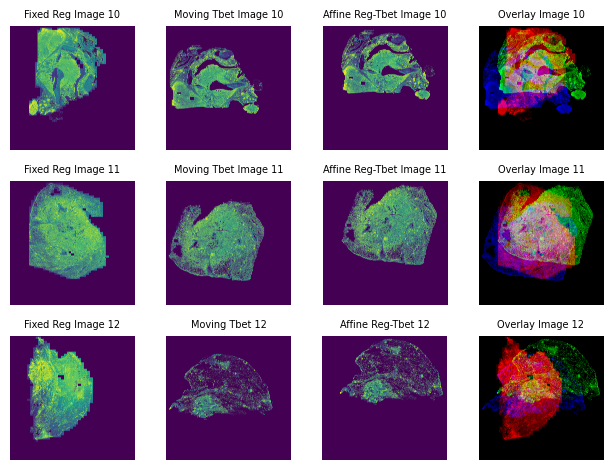

In [253]:
#Visualize the results
plt.subplot(3,4,1)
fixed_10 = exposure.equalize_hist(reg_image_cropped_ants_10_padded.numpy())
plt.imshow(fixed_10)
plt.title('Fixed Reg Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
moving_10 = exposure.equalize_hist(tbet_image_cropped_ants_10_padded.numpy())
plt.imshow(moving_10)
plt.title('Moving Tbet Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_10 = exposure.equalize_hist(affine_transformed_image_10.numpy())
plt.imshow(registered_10)
plt.title('Affine Reg-Tbet Image 1',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_10_normalized = (fixed_10 - fixed_10.min()) / (fixed_10.max() - fixed_10.min())
registered_10_normalized = (registered_10 - registered_10.min()) / (registered_10.max() - registered_10.min())
moving_10_normalized = (moving_10 - moving_10.min()) / (moving_10.max() - moving_10.min())

#Overlay for the first image
plt.subplot(3, 4, 4)
overlay_10 = np.stack([fixed_10_normalized, registered_10_normalized, moving_10_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_10)
plt.title('Overlay Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_11 = exposure.equalize_hist(reg_image_cropped_ants_11_padded.numpy())
plt.imshow(fixed_11)
plt.title('Fixed Reg Image 2',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_11 = exposure.equalize_hist(tbet_image_cropped_ants_11_padded.numpy())
plt.imshow(moving_11)
plt.title('Moving Tbet Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_11 = exposure.equalize_hist(affine_transformed_image_11.numpy())
plt.imshow(registered_11)
plt.title('Affine Reg-Tbet Image 2',fontsize=7)

plt.axis('off')
# Normalize the images to [0, 1] for proper overlay visualization
fixed_11_normalized = (fixed_11 - fixed_11.min()) / (fixed_11.max() - fixed_11.min())
registered_11_normalized = (registered_11 - registered_11.min()) / (registered_11.max() - registered_11.min())
moving_11_normalized = (moving_11 - moving_11.min()) / (moving_11.max() - moving_11.min())

#Overlay for the second image
plt.subplot(3, 4, 8)
overlay_11 = np.stack([fixed_11_normalized, registered_11_normalized, moving_11_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_11)
plt.title('Overlay Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
fixed_12 = exposure.equalize_hist(reg_image_cropped_ants_12_padded.numpy())
plt.imshow(fixed_12)
plt.title('Fixed Reg Image 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
moving_12 = exposure.equalize_hist(tbet_image_cropped_ants_12_padded.numpy())
plt.imshow(moving_12)
plt.title('Moving Tbet Image 3' ,fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
registered_12 = exposure.equalize_hist(affine_result_12['warpedmovout'].numpy())
plt.imshow(registered_12)
plt.title('Affine Reg-Tbet 3',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_12_normalized = (fixed_12 - fixed_12.min()) / (fixed_12.max() - fixed_12.min())
registered_12_normalized = (registered_12 - registered_12.min()) / (registered_12.max() - registered_12.min())
moving_12_normalized = (moving_12 - moving_12.min()) / (moving_12.max() - moving_12.min())

#Overlay for the third image
plt.subplot(3,4,12)
overlay_12 = np.stack([fixed_12_normalized, registered_12_normalized, moving_12_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_12)
plt.title('Overlay Image 3', fontsize=7)
plt.axis('off')

plt.tight_layout()
plt.show()

In [90]:
#View image metadata
affine_result_10

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -1024.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-1024.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image10_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image10_0GenericAffine.mat']}

In [91]:
#Get transform parameters
fwd_aff_10 = ants.read_transform(affine_result_10['fwdtransforms'][0])
fwd_aff_10.parameters

array([ 9.31007981e-01, -3.30377102e-01,  3.41043770e-01,  9.55301344e-01,
        8.28089355e+02,  4.78934021e+02])

In [92]:
fwd_aff_10.fixed_parameters

array([41.98567581, 35.21538925])

In [93]:
#View image metadata
affine_result_11

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -1024.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-1024.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image11_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image11_0GenericAffine.mat']}

In [94]:
#Get transform parameters
fwd_aff_11 = ants.read_transform(affine_result_11['fwdtransforms'][0])
fwd_aff_11.parameters

array([ 8.94675970e-01,  2.53715932e-01, -3.34133595e-01,  1.08230448e+00,
       -9.33630737e+02,  1.73424805e+03])

In [95]:
fwd_aff_11.fixed_parameters

array([52.7854805 , 42.12069702])

In [96]:
#View image metadata
affine_result_12

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -1024.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-1024.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image12_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image12_0GenericAffine.mat']}

In [97]:
#Get transform parameters
fwd_aff_12 = ants.read_transform(affine_result_12['fwdtransforms'][0])
fwd_aff_12.parameters

array([ 9.28569496e-01,  2.96882331e-01, -3.61937791e-01,  1.10816538e+00,
       -1.11781873e+03,  1.89220569e+03])

In [98]:
fwd_aff_12.fixed_parameters

array([50.77205276, 28.47519302])

### Metrics

In [100]:
#Compute mutual information between the fixed regression and  transformed reg-tbet image pre/post registration
mi10_pre = ants.image_mutual_information(reg_image_cropped_ants_10_padded, tbet_image_cropped_ants_10_padded)
mi11_pre = ants.image_mutual_information(reg_image_cropped_ants_11_padded, tbet_image_cropped_ants_11_padded)
mi12_pre = ants.image_mutual_information(reg_image_cropped_ants_12_padded, tbet_image_cropped_ants_12_padded)

mi10_post = ants.image_mutual_information(reg_image_cropped_ants_10_padded, affine_transformed_image_10)
mi11_post = ants.image_mutual_information(reg_image_cropped_ants_11_padded, affine_transformed_image_11)
mi12_post = ants.image_mutual_information(reg_image_cropped_ants_12_padded, affine_transformed_image_12)

#Compute normalized cross correlation between the fixed regression and  transformed reg-tbet image pre/post registration
cc10_pre = ants.math.image_similarity(reg_image_cropped_ants_10_padded,tbet_image_cropped_ants_10_padded, 'Correlation')
cc11_pre = ants.math.image_similarity(reg_image_cropped_ants_11_padded, tbet_image_cropped_ants_11_padded, 'Correlation')
cc12_pre = ants.math.image_similarity(reg_image_cropped_ants_12_padded, tbet_image_cropped_ants_12_padded, 'Correlation')

cc10_post = ants.math.image_similarity(reg_image_cropped_ants_10_padded, affine_transformed_image_10, 'Correlation')
cc11_post = ants.math.image_similarity(reg_image_cropped_ants_11_padded, affine_transformed_image_11, 'Correlation')
cc12_post  = ants.math.image_similarity(reg_image_cropped_ants_12_padded, affine_transformed_image_12, 'Correlation')

#Compute mean squares between the fixed regression and  transformed axis-reg image reg-tbet registration
mse10_pre = ants.math.image_similarity(reg_image_cropped_ants_10_padded,tbet_image_cropped_ants_10_padded, 'MeanSquares')
mse11_pre = ants.math.image_similarity(reg_image_cropped_ants_11_padded, tbet_image_cropped_ants_11_padded, 'MeanSquares')
mse12_pre = ants.math.image_similarity(reg_image_cropped_ants_12_padded, tbet_image_cropped_ants_12_padded, 'MeanSquares')

mse10_post = ants.math.image_similarity(reg_image_cropped_ants_10_padded, affine_transformed_image_10, 'MeanSquares')
mse11_post = ants.math.image_similarity(reg_image_cropped_ants_11_padded,affine_transformed_image_11, 'MeanSquares')
mse12_post = ants.math.image_similarity(reg_image_cropped_ants_12_padded, affine_transformed_image_12, 'MeanSquares')

In [101]:
# Binarize the arrays (threshold = 0.5) to create binary masks

reg_image_cropped_ants_10_binary = (reg_image_cropped_ants_10_padded.numpy() > 0.5).astype(int)
reg_image_cropped_ants_11_binary = (reg_image_cropped_ants_11_padded.numpy() > 0.5).astype(int)
reg_image_cropped_ants_12_binary = (reg_image_cropped_ants_12_padded.numpy() > 0.5).astype(int)

tbet_image_cropped_ants_10_binary = (tbet_image_cropped_ants_10_padded.numpy() > 0.5).astype(int)
tbet_image_cropped_ants_11_binary = (tbet_image_cropped_ants_11_padded.numpy() > 0.5).astype(int)
tbet_image_cropped_ants_12_binary = (tbet_image_cropped_ants_12_padded.numpy() > 0.5).astype(int)

affine_result_10_binary = (affine_transformed_image_10.numpy() > 0.5).astype(int)
affine_result_11_binary = (affine_transformed_image_11.numpy() > 0.5).astype(int)
affine_result_12_binary = (affine_transformed_image_12.numpy() > 0.5).astype(int)


In [102]:
# Compute Jaccard Index pre/post registration
jaccard_10_pre = jaccard_score(reg_image_cropped_ants_10_binary.flatten(), tbet_image_cropped_ants_10_binary.flatten())
jaccard_11_pre = jaccard_score(reg_image_cropped_ants_11_binary.flatten(), tbet_image_cropped_ants_11_binary.flatten())
jaccard_12_pre = jaccard_score(reg_image_cropped_ants_12_binary.flatten(), tbet_image_cropped_ants_12_binary.flatten())

jaccard_10_post = jaccard_score(reg_image_cropped_ants_10_binary.flatten(), affine_result_10_binary.flatten())
jaccard_11_post = jaccard_score(reg_image_cropped_ants_11_binary.flatten(), affine_result_11_binary.flatten())
jaccard_12_post = jaccard_score(reg_image_cropped_ants_12_binary.flatten(), affine_result_12_binary.flatten())


In [103]:
#Convert the images to SimpleITK format
sitk_initial_image_10 = sitk.GetImageFromArray(reg_image_cropped_ants_10_padded.numpy())
sitk_moving_image_10 = sitk.GetImageFromArray(tbet_image_cropped_ants_10_padded.numpy())
sitk_final_image_10 = sitk.GetImageFromArray(affine_transformed_image_10.numpy())

sitk_initial_image_11 = sitk.GetImageFromArray(reg_image_cropped_ants_11_padded.numpy())
sitk_moving_image_11 = sitk.GetImageFromArray(tbet_image_cropped_ants_11_padded.numpy())
sitk_final_image_11 = sitk.GetImageFromArray(affine_transformed_image_11.numpy())

sitk_initial_image_12 = sitk.GetImageFromArray(reg_image_cropped_ants_12_padded.numpy())
sitk_moving_image_12 = sitk.GetImageFromArray(tbet_image_cropped_ants_12_padded.numpy())
sitk_final_image_12 = sitk.GetImageFromArray(affine_transformed_image_12.numpy())

# Compute Hausdorff Distance using SimpleITK
hausdorff_filter_10_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_10_pre.Execute(sitk_initial_image_10, sitk_moving_image_10)
hausdorff_sitk_10_pre = hausdorff_filter_10_pre.GetHausdorffDistance()

hausdorff_filter_10_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_10_post.Execute(sitk_initial_image_10, sitk_final_image_10)
hausdorff_sitk_10_post = hausdorff_filter_10_post.GetHausdorffDistance()
hausdorff_filter_11_pre = sitk.HausdorffDistanceImageFilter()

hausdorff_filter_11_pre.Execute(sitk_initial_image_11, sitk_moving_image_11)
hausdorff_sitk_11_pre = hausdorff_filter_11_pre.GetHausdorffDistance()

hausdorff_filter_11_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_11_post.Execute(sitk_initial_image_11, sitk_final_image_11)
hausdorff_sitk_11_post = hausdorff_filter_11_post.GetHausdorffDistance()

hausdorff_filter_12_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_12_pre.Execute(sitk_initial_image_12, sitk_moving_image_12)
hausdorff_sitk_12_pre = hausdorff_filter_12_pre.GetHausdorffDistance()

hausdorff_filter_12_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_12_post.Execute(sitk_initial_image_12, sitk_final_image_12)
hausdorff_sitk_12_post = hausdorff_filter_12_post.GetHausdorffDistance()


In [104]:
#Display the mi, cc, mse, jaccard, dice and hausdorff distance as graphs
metrics_df_4 = pd.DataFrame({
    'Sample': ['Reg-Tbet Image 10', 'Reg-Tbet Image 11', 'Reg-Tbet Image 12'],
    'MI_pre': [mi10_pre, mi11_pre, mi12_pre],
    'MI_post': [mi10_post, mi11_post, mi12_post],
    'CC_pre': [cc10_pre, cc11_pre, cc12_pre],
    'CC_post': [cc10_post, cc11_post, cc12_post],
    'MSE_pre': [mse10_pre, mse11_pre, mse12_pre],
    'MSE_post': [mse10_post, mse11_post, mse12_post],
    'Jaccard_pre': [jaccard_10_pre, jaccard_11_pre, jaccard_12_pre],
    'Jaccard_post': [jaccard_10_post, jaccard_11_post, jaccard_12_post],
    'Dice_pre': [dice7_pre, dice8_pre, dice9_pre],
    'Dice_post': [dice7_post, dice8_post, dice9_post],
    'Hausdorff_pre': [hausdorff_sitk_10_pre, hausdorff_sitk_11_pre, hausdorff_sitk_12_pre],
    'Hausdorff_post': [hausdorff_sitk_10_post, hausdorff_sitk_11_post, hausdorff_sitk_12_post]
})

metrics_df_4

,Sample,MI_pre,MI_post,CC_pre,CC_post,MSE_pre,MSE_post,Jaccard_pre,Jaccard_post,Dice_pre,Dice_post,Hausdorff_pre,Hausdorff_post
0,Reg-Tbet Image 10,-0.005160,-0.008190,-0.018008,-0.030145,14.127874,9.498293,0.256168,0.336974,0.447680,0.535715,1538.001300,1917.213082
1,Reg-Tbet Image 11,-0.005756,-0.014348,-0.049256,-0.137423,12.454915,7.073752,0.483985,0.588236,0.749546,0.839960,1494.968227,1038.519138
2,Reg-Tbet Image 12,-0.000274,-0.002062,-0.001974,-0.019283,14.971157,8.321103,0.193465,0.244816,0.435243,0.531092,1654.366646,1667.708008


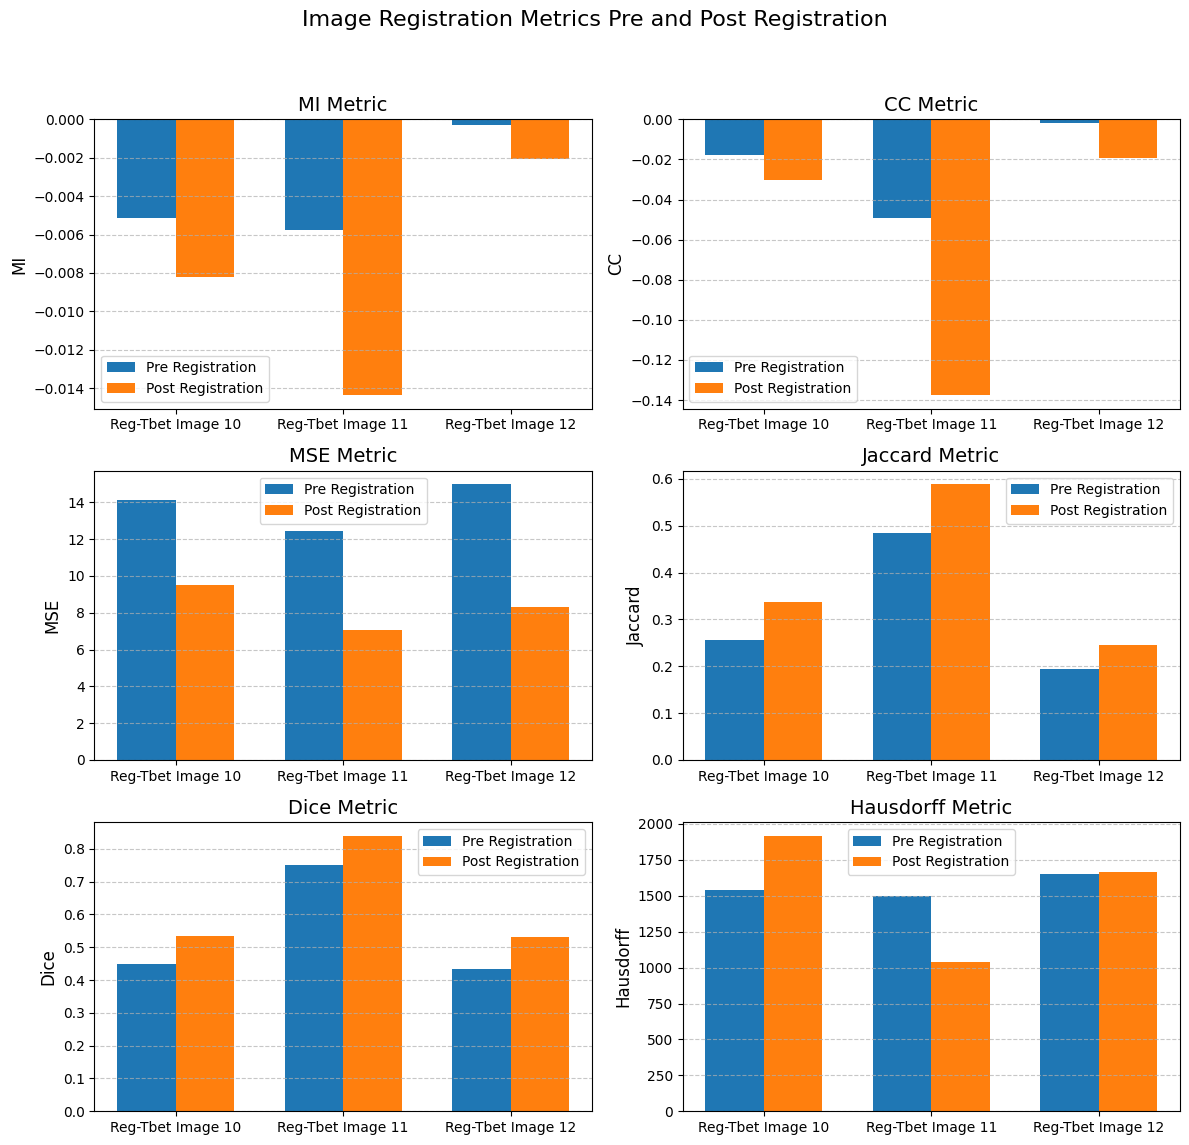

In [105]:
#Create a separate graph for each metric. Each graph should have 2 bars, one for pre registration and one for post registration
# Create a figure with subplots
fig_3, axes_3 = plt.subplots(3, 2, figsize=(12, 12))
# Set the figure title
fig_3.suptitle('Image Registration Metrics Pre and Post Registration', fontsize=16)
# Set the bar width
bar_width_3 = 0.35
# Set the bar positions
bar_positions_3 = np.arange(len(metrics_df_4['Sample']))
# Set the colors for the bars
colors_3 = ['#1f77b4', '#ff7f0e']  # Blue and Orange
# Set the bar labels
bar_labels_3 = ['Pre Registration', 'Post Registration']
# Set the metrics to plot
metrics_to_plot_3= ['MI', 'CC', 'MSE', 'Jaccard', 'Dice', 'Hausdorff']
# Loop through each metric and create a bar plot

for i, metric in enumerate(metrics_to_plot_3):
    # Create a bar plot for the metric
    axes_3[i // 2, i % 2].bar(bar_positions_3 - bar_width_3/2, metrics_df_4[f'{metric}_pre'], width=bar_width_3, label='Pre Registration', color=colors_3[0])
    axes_3[i // 2, i % 2].bar(bar_positions_3 + bar_width_3/2, metrics_df_4[f'{metric}_post'], width=bar_width_3, label='Post Registration', color=colors_3[1])

    # Set the x-ticks and labels
    axes_3[i // 2, i % 2].set_xticks(bar_positions_3)
    axes_3[i // 2, i % 2].set_xticklabels(metrics_df_4['Sample'])
    # Set the title and labels
    axes_3[i // 2, i % 2].set_title(f'{metric} Metric', fontsize=14)
    axes_3[i // 2, i % 2].set_ylabel(metric, fontsize=12)
    axes_3[i // 2, i % 2].legend()
    # Set grid lines
    axes_3[i // 2, i % 2].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [109]:
# Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels
#Each different row represents a different tissue

merged_df_4 = pd.concat([row_1, row_2, row_3], ignore_index=True)
#Add columns to the merged DataFrame
merged_df_4['scale'] = [3,3,3]
merged_df_4['final_image_parameters'] = [fwd_aff_10.parameters,fwd_aff_11.parameters,fwd_aff_12.parameters]
merged_df_4['final_image_fixed_parameters'] = [fwd_aff_10.fixed_parameters,fwd_aff_11.fixed_parameters,fwd_aff_12.fixed_parameters]
merged_df_4

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_parameters,final_image_fixed_parameters
0,101,709.0,834.0,L1_2,LY1,AP0140001,3,"[0.931007981300354, -0.33037710189819336, 0.34...","[41.98567581176758, 35.215389251708984]"
1,107,710.0,835.0,L2_4,LY2,AP0140002,3,"[0.8946759700775146, 0.2537159323692322, -0.33...","[52.78548049926758, 42.120697021484375]"
2,535,712.0,837.0,L4_3,LY4,AP0140004,3,"[0.928569495677948, 0.2968823313713074, -0.361...","[50.77205276489258, 28.47519302368164]"


In [110]:
merged_df_4.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_3.csv', index=False)

## Symmetric Deformable Registration (Scale 2)

### Load in spatial data

In [111]:
#Loop through each image in sp.images and crop it
cropped_images_5 = {}
for sampleid in sp.images:
    cropped_images_5[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=2)[0]


#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time
panel_5 = ['regression','tbet']*3
panel_df_5 = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframe
cropped_images_dimensions_5 = {}
for sampleid, cropped_image in cropped_images_5.items():
    cropped_images_dimensions_5[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }

cropped_images_dimensions_df_5 = pd.DataFrame.from_dict(cropped_images_dimensions_5, orient='index')
#Add the panel column to the cropped images dimensions dataframe
cropped_images_dimensions_df_5['panel'] = panel_df_5['panel'].values
cropped_images_dimensions_df_5

,dimensions,data_type,coordinates,panel
sampleid_709_image,"(16384, 12288)",float32,"[c, y, x]",regression
sampleid_834_image,"(12288, 16384)",float32,"[c, y, x]",tbet
sampleid_710_image,"(16384, 12288)",float32,"[c, y, x]",regression
sampleid_835_image,"(12288, 16384)",float32,"[c, y, x]",tbet
sampleid_712_image,"(16384, 12288)",float32,"[c, y, x]",regression
sampleid_837_image,"(12288, 16384)",float32,"[c, y, x]",tbet


In [112]:
#Convret the cropped images to ants
reg_image_cropped_ants_13 = ants.from_numpy(cropped_images_5[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_13 = ants.from_numpy(cropped_images_5[f'sampleid_{results[0]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_14 = ants.from_numpy(cropped_images_5[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_14 = ants.from_numpy(cropped_images_5[f'sampleid_{results[1]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_15 = ants.from_numpy(cropped_images_5[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_15 = ants.from_numpy(cropped_images_5[f'sampleid_{results[2]["tbet_sampleid"]}_image'].compute().data)

In [114]:
#Pad the images so they are the same size

reg_image_cropped_shape_13 = reg_image_cropped_ants_13.shape
tbet_image_cropped_shape_13= tbet_image_cropped_ants_13.shape

reg_image_cropped_shape_14 = reg_image_cropped_ants_14.shape
tbet_image_cropped_shape_14= tbet_image_cropped_ants_14.shape

reg_image_cropped_shape_15 = reg_image_cropped_ants_15.shape
tbet_image_cropped_shape_15= tbet_image_cropped_ants_15.shape


#Get the target shapes for padding
target_shape_13_x = max(reg_image_cropped_shape_13[0],tbet_image_cropped_shape_13[0])
target_shape_13_y = max(reg_image_cropped_shape_13[1],tbet_image_cropped_shape_13[1])

target_shape_14_x = max(reg_image_cropped_shape_14[0],tbet_image_cropped_shape_14[0])
target_shape_14_y = max(reg_image_cropped_shape_14[1],tbet_image_cropped_shape_14[1])

target_shape_15_x = max(reg_image_cropped_shape_15[0],tbet_image_cropped_shape_15[0])
target_shape_15_y = max(reg_image_cropped_shape_15[1],tbet_image_cropped_shape_15[1])

#Calculate the padding
pad_reg_X_13 = (0,target_shape_13_x-reg_image_cropped_shape_13[0])
pad_reg_Y_13 = (0,target_shape_13_y-reg_image_cropped_shape_13[1])

pad_reg_X_14 = (0,target_shape_14_x-reg_image_cropped_shape_14[0])
pad_reg_Y_14 = (0,target_shape_14_y-reg_image_cropped_shape_14[1])

pad_reg_X_15 = (0,target_shape_15_x-reg_image_cropped_shape_15[0])
pad_reg_Y_15 = (0,target_shape_15_y-reg_image_cropped_shape_15[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_13_padded = ants.pad_image(reg_image_cropped_ants_13, (target_shape_13_x,target_shape_13_y))
reg_image_cropped_ants_14_padded = ants.pad_image(reg_image_cropped_ants_14, (target_shape_14_x,target_shape_14_y))
reg_image_cropped_ants_15_padded = ants.pad_image(reg_image_cropped_ants_15, (target_shape_15_x,target_shape_15_y))

# Pad the tbet images to match the size of the rigid transformed images
tbet_image_cropped_ants_13_padded = ants.pad_image(tbet_image_cropped_ants_13, (target_shape_13_x,target_shape_13_y))
tbet_image_cropped_ants_14_padded = ants.pad_image(tbet_image_cropped_ants_14, (target_shape_14_x,target_shape_14_y))
tbet_image_cropped_ants_15_padded = ants.pad_image(tbet_image_cropped_ants_15, (target_shape_15_x,target_shape_15_y))

# Print the shapes of the padded images
print("Padded regression image shape 13: ", reg_image_cropped_ants_13_padded.shape)
print("Padded regression image shape 14: ", reg_image_cropped_ants_14_padded.shape)
print("Padded regression image shape 15: ", reg_image_cropped_ants_15_padded.shape,"\n")

print("Padded tbet image shape 13: ", tbet_image_cropped_ants_13_padded.shape)
print("Padded tbet image shape 14: ", tbet_image_cropped_ants_14_padded.shape)
print("Padded tbet image shape 15: ", tbet_image_cropped_ants_15_padded.shape,"\n")


Padded regression image shape 13:  (16384, 16384)
Padded regression image shape 14:  (16384, 16384)
Padded regression image shape 15:  (16384, 16384) 

Padded tbet image shape 13:  (16384, 16384)
Padded tbet image shape 14:  (16384, 16384)
Padded tbet image shape 15:  (16384, 16384) 



### Scale and apply registration parameters at lower resolution to higher resolution image

In [115]:
# Compute scaling factors
scaling_factor_10 = compute_scaling_factor(sp.images[f'{reg_name_1}']['scale2'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_1}']['scale3'].image.transform['scale0'].scale[0])
scaling_factor_11 = compute_scaling_factor(sp.images[f'{reg_name_2}']['scale2'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_2}']['scale3'].image.transform['scale0'].scale[0])
scaling_factor_12 = compute_scaling_factor(sp.images[f'{reg_name_3}']['scale2'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_3}']['scale3'].image.transform['scale0'].scale[0])

### ANTS Symmetric Deformable transform

In [ ]:
#Divide image into sections


In [329]:

#Apply the scaling factors to the transformations
scaled_transform_13 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine.mat',
    scaling_factor_10
)

# Apply the scaled transformation to the image
affine_transformed_image_13 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_13_padded,
    moving=tbet_image_cropped_ants_13_padded,
    transformlist=scaled_transform_13
)

# Perform SyN registration first on the image
syn_result_13 = ants.registration(  
    fixed=affine_transformed_image_13,
    moving=tbet_image_cropped_ants_13_padded,
    type_of_transform='SyN',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_syn_registration_image13_'
)

# Apply the scaling factors to the transformations
scaled_transform_14 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_0GenericAffine.mat',
    scaling_factor_11
)

# Apply the scaled transformation to the image
affine_transformed_image_14 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_14_padded,
    moving=tbet_image_cropped_ants_14_padded,
    transformlist=scaled_transform_14
)

# Perform SyN registration first on the image
syn_result_14 = ants.registration( 
    fixed=affine_transformed_image_14,
    moving=tbet_image_cropped_ants_14_padded,
    type_of_transform='SyN',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_syn_registration_image14_'
)

# Apply the scaling factors to the transformations
scaled_transform_15 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_0GenericAffine.mat',
    scaling_factor_12
)

# Apply the scaled transformation to the image
affine_transformed_image_15 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_15_padded,
    moving=tbet_image_cropped_ants_15_padded,
    transformlist=scaled_transform_15
)

# Perform SyN registration first on the image
syn_result_15 = ants.registration(
    fixed=affine_transformed_image_15,
    moving=tbet_image_cropped_ants_15_padded,
    type_of_transform='SyN',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_syn_registration_image15_'
)

RuntimeError: D:\a\ANTsPy\ANTsPy\itksource\Modules\Core\Common\include\itkImportImageContainer.hxx:179:
Failed to allocate memory for image.

In [ ]:
#Visualize the results
plt.subplot(3,4,1)
fixed_10 = exposure.equalize_hist(reg_image_cropped_ants_10_padded.numpy())
plt.imshow(fixed_10)
plt.title('Fixed Reg Image 10',fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
moving_10 = exposure.equalize_hist(tbet_image_cropped_ants_10_padded.numpy())
plt.imshow(moving_10)
plt.title('Moving Tbet Image 10',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_10 = exposure.equalize_hist(affine_result_10['warpedmovout'].numpy())
plt.imshow(registered_10)
plt.title('Affine Reg-Tbet Image 10',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_10_normalized = (fixed_10 - fixed_10.min()) / (fixed_10.max() - fixed_10.min())
registered_10_normalized = (registered_10 - registered_10.min()) / (registered_10.max() - registered_10.min())
moving_10_normalized = (moving_10 - moving_10.min()) / (moving_10.max() - moving_10.min())

#Overlay for the first image
plt.subplot(3, 4, 4)
overlay_10 = np.stack([fixed_10_normalized, registered_10_normalized, moving_10_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_10)
plt.title('Overlay Image 10', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_11 = exposure.equalize_hist(reg_image_cropped_ants_11_padded.numpy())
plt.imshow(fixed_11)
plt.title('Fixed Reg Image 11',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_11 = exposure.equalize_hist(tbet_image_cropped_ants_11_padded.numpy())
plt.imshow(moving_11)
plt.title('Moving Tbet Image 11', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_11 = exposure.equalize_hist(affine_result_11['warpedmovout'].numpy())
plt.imshow(registered_11)
plt.title('Affine Reg-Tbet Image 11',fontsize=7)

plt.axis('off')
# Normalize the images to [0, 1] for proper overlay visualization
fixed_11_normalized = (fixed_11 - fixed_11.min()) / (fixed_11.max() - fixed_11.min())
registered_11_normalized = (registered_11 - registered_11.min()) / (registered_11.max() - registered_11.min())
moving_11_normalized = (moving_11 - moving_11.min()) / (moving_11.max() - moving_11.min())

#Overlay for the second image
plt.subplot(3, 4, 8)
overlay_11 = np.stack([fixed_11_normalized, registered_11_normalized, moving_11_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_11)
plt.title('Overlay Image 11', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
fixed_12 = exposure.equalize_hist(reg_image_cropped_ants_12_padded.numpy())
plt.imshow(fixed_12)
plt.title('Fixed Reg Image 12',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
moving_12 = exposure.equalize_hist(tbet_image_cropped_ants_12_padded.numpy())
plt.imshow(moving_12)
plt.title('Moving Tbet 12',fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
registered_12 = exposure.equalize_hist(affine_result_12['warpedmovout'].numpy())
plt.imshow(registered_12)
plt.title('Affine Reg-Tbet 12',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_12_normalized = (fixed_12 - fixed_12.min()) / (fixed_12.max() - fixed_12.min())
registered_12_normalized = (registered_12 - registered_12.min()) / (registered_12.max() - registered_12.min())
moving_12_normalized = (moving_12 - moving_12.min()) / (moving_12.max() - moving_12.min())

#Overlay for the third image
plt.subplot(3,4,12)
overlay_12 = np.stack([fixed_12_normalized, registered_12_normalized, moving_12_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_12)
plt.title('Overlay Image 12', fontsize=7)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#One matrix should be zeros as it the one being registered to the other. 
#Two tables one for axis and one for tbet. Tbet to regression and axis to regression
#Similarity metrics from transformed axis to regression. Transformed tbet to regression. Transformed axis to tbet (could be to validate registration)


In [ ]:

#Sources:

# https://pmc.ncbi.nlm.nih.gov/articles/PMC7584382/

#https://pubmed.ncbi.nlm.nih.gov/38632390/ 

#https://www.nature.com/articles/s41598-021-87564-6 

#Multi-resolution registration:
#https://discourse.itk.org/t/multiresolution-registration-with-2d-affine-transformation-on-pairs-of-2d-images/3096/10